In [ ]:
# --- USER CONFIG ---
START_YEAR = 2000
END_YEAR   = 2024

# Horizons to compute (use last day of month as cutoff)
HORIZONS = {
    "FEB": {"month": 2,  "label": "FEB"},
    "MAR": {"month": 3,  "label": "MAR"},
    "APR": {"month": 4,  "label": "APR"},
    "MAY": {"month": 5,  "label": "MAY"},
    "JUN": {"month": 6,  "label": "JUN"},
    "JUL": {"month": 7,  "label": "JUL"},
    "AUG": {"month": 8,  "label": "AUG"},
}

# Paths (cache)
DATA_DIR = "data_cache"
PRISM_DIR = f"{DATA_DIR}/prism"
GLDAS_DIR = f"{DATA_DIR}/gldas"
USDM_DIR  = f"{DATA_DIR}/usdm"
CDL_DIR   = f"{DATA_DIR}/cdl"
SOIL_DIR  = f"{DATA_DIR}/soils"
NDVI_DIR  = f"{DATA_DIR}/ndvi"
AUX_DIR   = f"{DATA_DIR}/aux"

# 🔐 Credentials (fill in as needed)
# NASA Earthdata (GLDAS). You should also create a ~/.netrc file for requests to use.
EARTHDATA_USERNAME = "rocketman01"
EARTHDATA_PASSWORD = "Starship05!"

# NASS QuickStats
NASS_API_KEY = "606153B9-DDAD-30FB-88EE-5BCC60DEE678"

# AppEEARS (optional for MODIS NDVI). If not provided, the Sentinel-2 fallback is used.
APPEEARS_TOKEN = None  # e.g., "eyJhbGciOi..."

# Diesel / Ethanol / Basis: we include example endpoints & parsers. Some require free registration.

In [20]:
!pip install torch

   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
    --------------------------------------- 2.4/109.3 MB 14.3 MB/s eta 0:00:08
   - -------------------------------------- 5.2/109.3 MB 14.4 MB/s eta 0:00:08
   -- ------------------------------------- 8.1/109.3 MB 14.4 MB/s eta 0:00:08
   ---- ----------------------------------- 11.3/109.3 MB 14.4 MB/s eta 0:00:07
   ----- ---------------------------------- 14.2/109.3 MB 14.4 MB/s eta 0:00:07
   ------ --------------------------------- 17.0/109.3 MB 14.4 MB/s eta 0:00:07
   ------- -------------------------------- 19.9/109.3 MB 14.4 MB/s eta 0:00:07
   -------- ------------------------------- 22.8/109.3 MB 14.4 MB/s eta 0:00:07
   --------- ------------------------------ 25.7/109.3 MB 14.4 MB/s eta 0:00:06
   ---------- ----------------------------- 28.6/109.3 MB 14.3 MB/s eta 0:00:06
   ----------- ---------------------------- 31.5/109.3 MB 14.3 MB/s eta 0:00:06
   ------------ --------------------------- 34.3/109

In [1]:

# !pip install geopandas rasterio fiona shapely earthengine-api rnassqs pandas numpy folium
# Install required packages (run once)
!pip install geopandas rasterio fiona shapely earthengine-api pandas numpy folium geemap


  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached google_cloud_core-2.4.3-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached google_crc32c-1.7.1-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---- ----------------------------------- 2.9/25.4 MB 14.4 MB/s eta 0:00:02
   --------- ------------------------------ 5.8/25.4 MB 14.4 MB/s eta 0:00:02
   ------------- -------------------------- 8.7/25.4 MB 14.4 MB/s eta 0:00:02
   ------------------ --------------------- 11.5/25.4 MB 14.4 MB/s eta 0:00:01
   ---------------------- ----------------- 14.4/25.4 MB 14.4 MB/s eta 0:00:01
   --------------------------- ------------ 17.3/25.4 MB 14.4 MB/s eta 0:00:01
   ------

In [60]:
import urllib.request
import json
import pandas as pd

base_url = 'https://quickstats.nass.usda.gov/api/api_GET/'

# This is my own API key!
params = {
    'key': '606153B9-DDAD-30FB-88EE-5BCC60DEE678' ,
    'commodity_desc': 'CORN',
    'statisticcat_desc': 'PRODUCTION',
    'unit_desc': 'BU',
    'agg_level_desc': 'COUNTY',
    'state_name': 'MINNESOTA',
    'year__GE': '2000',
    'year__LE': '2024',
    'format': 'JSON'
}


query_string = '&'.join([f"{k}={v}" for k, v in params.items()])
full_url = base_url + '?' + query_string
with urllib.request.urlopen(full_url) as response:
    data = json.loads(response.read().decode())

corn_data = data['data']
corn_df = pd.DataFrame(corn_data)

corn_df = corn_df[['year', 'county_code', 'county_name', 'Value']]

# FIPS: Minnesota state code is 27, county_code is 3 digits
corn_df['fips'] = '27' + corn_df['county_code'].astype(str).str.zfill(3)

corn_df['Value'] = pd.to_numeric(corn_df['Value'].str.replace(',', '').replace('(D)', 'NaN'), errors='coerce')
corn_df = corn_df.rename(columns={'Value': 'corn_production_bu'})
corn_pivot = corn_df.pivot_table(index=['fips', 'county_name'], columns='year', values='corn_production_bu', aggfunc='first')

corn_pivot.to_csv('mn_county_corn_production_2000_2022.csv')
corn_df.head(5)


,year,county_code,county_name,corn_production_bu,fips
0,2022,005,BECKER,12090339.0,27005
1,2017,005,BECKER,9713439.0,27005
2,2012,005,BECKER,10498515.0,27005
3,2007,005,BECKER,4514135.0,27005
4,2002,005,BECKER,1629672.0,27005


In [67]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import folium 
import matplotlib.pyplot as plt

# URL to Minnesota counties shapefile for geo location

mn_counties = gpd.read_file('Minnesota/mn_shp_bdry_counties.zip')
mn_counties.head(5)

mn_counties['COUNTY_COD']


0     63
1     27
2     73
3     71
4     51
      ..
82    54
83    25
84    19
85    22
86    81
Name: COUNTY_COD, Length: 87, dtype: object

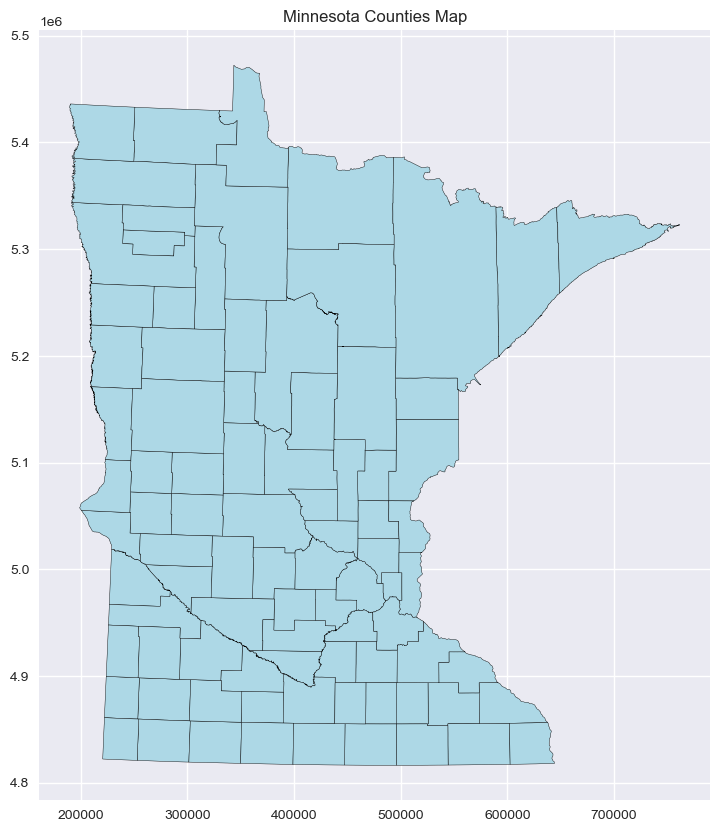

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
mn_counties.plot(ax=ax, edgecolor='black', color='lightblue')
ax.set_title('Minnesota Counties Map')
plt.show()

In [1]:
# import counties
import ee

ee.Authenticate()
ee.Initialize()

ee_counties = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '27'))

ee_counties

In [5]:
import ee
import pandas as pd
import numpy as np
import geemap
import itertools
from tqdm import tqdm

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define years and months
years = list(range(2000, 2023))
months = list(range(2, 9))  # Feb to Aug

# Modified function to extract averages for all bands using TIGER counties for Minnesota
def get_county_averages_multi_band(collection, start_date, end_date):
    image = collection.filterDate(start_date, end_date).mean()
    
    # Get list of all band names
    band_names = image.bandNames().getInfo()
     
    # Load Minnesota counties from TIGER dataset
    ee_counties = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '27'))
    
    # Reduce regions
    stats = image.reduceRegions(collection=ee_counties, reducer=ee.Reducer.mean(), scale=1000)
    results = stats.getInfo()
    
    data = []
    for feature in results['features']:
        props = feature['properties']
        row = {
            'fips': props['GEOID'],
            'county_name': props['NAME']
        }
        for band in band_names:
            row[band] = props.get(band, np.nan)
        data.append(row)
    return pd.DataFrame(data)

# GLDAS Collection (all 36 bands)
gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H')

# Initialize dataframe for GLDAS data (all bands)
gldas_data = pd.DataFrame()

# Calculate total iterations for progress bar
total_iterations = len(years) * len(months)

# Loop over years and months to collect data with progress bar
for year, month in tqdm(itertools.product(years, months), total=total_iterations, desc="Downloading GLDAS Data"):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    # Get averages for all bands
    monthly_data = get_county_averages_multi_band(gldas, start_date, end_date)
    
    # Add year and month columns
    monthly_data['year'] = year
    monthly_data['month'] = month
    
    # Append to main dataframe
    gldas_data = pd.concat([gldas_data, monthly_data], ignore_index=True)



# Optional: Visualize first image (example for one band)
Map = geemap.Map()
vis_params = {'bands': ['SoilMoi0_10cm_inst'], 'min': 0, 'max': 0.3}
image = gldas.first()
Map.addLayer(image, vis_params, 'First Image')
Map

# Display or save the data
print(gldas_data.head())
gldas_data.to_csv('gldas_all_bands_data.csv', index=False)

AttributeError: module 'ee.data' has no attribute '_credentials'

In [16]:
import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()


# Calculate total iterations for progress bar
total_iterations = len(years) * len(months)


# Display the first image from GLDAS for verification, adding layers for all 36 bands
Map = geemap.Map(center=[46.4, -94.5], zoom=6)  # Center on Minnesota

# Define band-specific min/max from dataset documentation (estimated values)
band_vis_dict = {
    'Albedo_inst': {'min': 4.99, 'max': 82.25},
    'AvgSurfT_inst': {'min': 187.48, 'max': 1323.35},
    'CanopInt_inst': {'min': 0, 'max': 0.5},
    'ECanop_tavg': {'min': 0, 'max': 1273.66},
    'ESoil_tavg': {'min': 0, 'max': 2275.63},
    'Evap_tavg': {'min': 0, 'max': 0.002},
    'LWdown_f_tavg': {'min': 26.85, 'max': 600.9},
    'Lwnet_tavg': {'min': -13792.7, 'max': 196.97},
    'PotEvap_tavg': {'min': -227.75, 'max': 18977.9},
    'Psurf_f_inst': {'min': 44063.1, 'max': 108344},
    'Qair_f_inst': {'min': -0.02, 'max': 0.07},
    'Qg_tavg': {'min': -552.64, 'max': 1538.41},
    'Qh_tavg': {'min': -1005.15, 'max': 18190.6},
    'Qle_tavg': {'min': -227.75, 'max': 5072.25},
    'Qs_acc': {'min': 0, 'max': 170.93},
    'Qsb_acc': {'min': 0, 'max': 50.6},
    'Qsm_acc': {'min': 0, 'max': 42.87},
    'Rainf_f_tavg': {'min': 0, 'max': 0.01},
    'Rainf_tavg': {'min': 0, 'max': 0.01},
    'RootMoist_inst': {'min': 2, 'max': 949.6},
    'SWE_inst': {'min': 0, 'max': 120787},
    'SWdown_f_tavg': {'min': -56.93, 'max': 30462.8},
    'SnowDepth_inst': {'min': 0, 'max': 301.96},
    'Snowf_tavg': {'min': 0, 'max': 0.009},
    'SoilMoi0_10cm_inst': {'min': 1.99, 'max': 47.59},
    'SoilMoi10_40cm_inst': {'min': 5.99, 'max': 142.8},
    'SoilMoi40_100cm_inst': {'min': 11.99, 'max': 285.6},
    'SoilMoi100_200cm_inst': {'min': 20, 'max': 476},
    'SoilTMP0_10cm_inst': {'min': 221.98, 'max': 377.5},
    'SoilTMP10_40cm_inst': {'min': 227.43, 'max': 319.44},
    'SoilTMP40_100cm_inst': {'min': 232.97, 'max': 316.2},
    'SoilTMP100_200cm_inst': {'min': 238.52, 'max': 314.11},
    'Swnet_tavg': {'min': -48.96, 'max': 23741.3},
    'Tair_f_inst': {'min': 206.8, 'max': 327.66},
    'Tveg_tavg': {'min': 0, 'max': 3455.14},
    'Wind_f_inst': {'min': 0, 'max': 57.7}
}

# Get a sample image (first from a specific date)
sample_gldas = gldas_data
image = sample_gldas.first()

# Get band names
band_names = image.bandNames().getInfo()

# Add a layer for each band with band-specific vis params
palette = ['blue', 'cyan', 'green', 'yellow', 'red']  # Common palette for visualization
for band in band_names:
    if band in band_vis_dict:
        vis_params = {
            'bands': [band],
            'min': band_vis_dict[band]['min'],
            'max': band_vis_dict[band]['max'],
            'palette': palette
        }
        Map.addLayer(image, vis_params, band)

# Print image info
print("First GLDAS Image Info:")
pprint.pprint(image.getInfo())

# Display the interactive map
display(Map)

AttributeError: module 'ee.data' has no attribute '_credentials'

In [17]:
gldas_data.head(10)

,fips,county_name,Albedo_inst,AvgSurfT_inst,CanopInt_inst,ECanop_tavg,ESoil_tavg,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,...,SoilTMP0_10cm_inst,SoilTMP100_200cm_inst,SoilTMP10_40cm_inst,SoilTMP40_100cm_inst,Swnet_tavg,Tair_f_inst,Tveg_tavg,Wind_f_inst,year,month
0,27073,Lac qui Parle,45.628617,268.901502,0.170420,0.094085,4.831143,0.000005,259.458295,-35.648687,...,268.826365,274.867397,268.464492,269.632552,50.665452,269.784213,0.000795,4.537589,2000,2
1,27153,Todd,56.148677,265.590273,0.206198,0.078237,2.168450,0.000003,249.600736,-31.664551,...,266.971425,274.416129,267.790632,268.883070,41.925469,266.853667,0.000045,4.124489,2000,2
2,27001,Aitkin,50.244838,264.970104,0.175215,0.102708,2.679327,0.000004,243.178305,-34.681887,...,267.489019,273.978808,268.936852,270.274443,46.623340,266.555530,0.000008,3.688226,2000,2
3,27057,Hubbard,48.491914,264.914661,0.210605,0.095990,2.421774,0.000003,244.762518,-32.901821,...,266.858855,273.354544,268.066121,269.214886,48.109217,266.127134,0.000000,3.601552,2000,2
4,27063,Jackson,50.091128,269.441418,0.199066,0.278989,5.146278,0.000006,262.570152,-35.010630,...,269.274922,274.986025,268.878458,269.894368,48.702200,270.714126,0.003282,4.948826,2000,2
5,27121,Pope,55.467326,266.598502,0.172878,0.066571,3.006990,0.000004,253.792306,-31.727923,...,267.257765,274.264386,267.444965,268.740709,41.898602,267.727905,0.000108,4.451930,2000,2
6,27133,Rock,42.564482,270.324059,0.274374,0.976635,7.152185,0.000007,261.111781,-40.138001,...,270.061416,274.832986,269.461307,270.602765,57.622371,271.552264,0.028276,4.929492,2000,2
7,27161,Waseca,60.938878,268.337954,0.212586,0.085138,3.804249,0.000004,261.592485,-31.446839,...,268.951645,274.711281,269.326730,270.336344,38.937740,269.758461,0.000332,4.627950,2000,2
8,27033,Cottonwood,51.272916,269.115287,0.200030,0.207269,4.903958,0.000005,262.924099,-33.385060,...,269.003126,275.162304,268.712094,270.027996,45.010653,270.378330,0.001719,4.842022,2000,2
9,27071,Koochiching,45.337337,263.930224,0.244704,0.173364,2.479977,0.000004,234.853488,-37.676858,...,266.478099,274.032957,268.054139,269.860281,53.137898,265.173850,0.000000,3.358798,2000,2


In [39]:
!pip install seaborn

In [22]:
gldas_path = 'Data/gldas_all_bands_data.csv'  
corn_prod_path = 'Data/mn_county_corn_production_2000_2022.csv'

In [27]:
data.head(5)

,year,fips,sequence,production
0,2000,27003,"[[58.361777093944845, 266.5877660170595, 0.240...",795600.0
1,2000,27005,"[[55.58346376470553, 264.6142973895659, 0.1956...",1449600.0
2,2000,27007,"[[48.49849138094897, 264.2412504187317, 0.2317...",78400.0
3,2000,27009,"[[58.02384233632291, 265.94676086831635, 0.195...",4967400.0
4,2000,27011,"[[45.956175943807885, 268.1887774500573, 0.150...",9841800.0


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define paths
gldas_path = 'Data/gldas_all_bands_data.csv'  
corn_prod_path = 'Data/mn_county_corn_production_2000_2022.csv'

# Load GLDAS data
gldas_df = pd.read_csv(gldas_path)

# Load corn production data
corn_df = pd.read_csv(corn_prod_path)

# Preprocess corn production: melt to long format
corn_df = corn_df.melt(id_vars=['fips', 'county_name'], var_name='year', value_name='production')
corn_df['year'] = corn_df['year'].astype(int)
corn_df['production'] = pd.to_numeric(corn_df['production'], errors='coerce')
corn_df = corn_df.dropna(subset=['production'])
corn_df['fips'] = corn_df['fips'].astype(str).str.zfill(5)

# Clip outliers in production (99th percentile)
production_cap = corn_df['production'].quantile(0.99)
corn_df['production'] = corn_df['production'].clip(upper=production_cap)

# Preprocess GLDAS: ensure fips is string, filter years 2000-2022
gldas_df['fips'] = gldas_df['fips'].astype(str).str.zfill(5)
gldas_df = gldas_df[gldas_df['year'].between(2000, 2022)]

# Get list of 36 bands
band_columns = [col for col in gldas_df.columns if col not in ['fips', 'county_name', 'year', 'month']]
assert len(band_columns) == 36, f"Expected 36 bands, found {len(band_columns)}"

# Handle missing values: fill with mean per band
for band in band_columns:
    gldas_df[band] = gldas_df[band].fillna(gldas_df[band].mean())

# Create time-series data
gldas_df = gldas_df.sort_values(['year', 'fips', 'month'])

def group_to_sequence(group):
    if len(group) != 7:
        return None
    sequence = group[band_columns].values  # Shape: (7, 36)
    return sequence

sequences = gldas_df.groupby(['year', 'fips']).apply(group_to_sequence).reset_index(name='sequence')
sequences = sequences.dropna()

# Merge with corn production targets
data = pd.merge(sequences, corn_df[['year', 'fips', 'production']], on=['year', 'fips'])

# Prepare X and y
X = np.stack(data['sequence'].values)  # Shape: (samples, 7 timesteps, 36 features)
y = data['production'].values

# Normalize features
scalers = {}
for i in range(X.shape[2]):
    scalers[i] = StandardScaler()
    X[:, :, i] = scalers[i].fit_transform(X[:, :, i].reshape(-1, 1)).reshape(X.shape[:2])

# Log-transform target
y = np.log1p(y)

# Split train/test: 2000-2020 train, 2021-2022 test
train_mask = data['year'] <= 2020
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

data.to_csv('gldas_all_bands_with_target.csv', index=False)

# Verify input shape
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")




X_train shape: (1564, 7, 36), y_train shape: (1564,)
X_test shape: (154, 7, 36), y_test shape: (154,)


Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 182.9039 - mae: 13.3282 - val_loss: 93.4036 - val_mae: 9.5300
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.9244 - mae: 5.1209 - val_loss: 9.9535 - val_mae: 2.4648
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2329 - mae: 2.3922 - val_loss: 3.0219 - val_mae: 1.4502
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3891 - mae: 1.8680 - val_loss: 2.3762 - val_mae: 1.1828
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4407 - mae: 1.6924 - val_loss: 1.9462 - val_mae: 1.0821
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9542 - mae: 1.5807 - val_loss: 1.7661 - val_mae: 1.0376
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5424 - mae: 1.5258 - val_loss: 1.5175 - val_mae: 0.9750
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6745 - mae: 1.5223 - val_loss: 1.4067 - val_mae: 0.9422
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

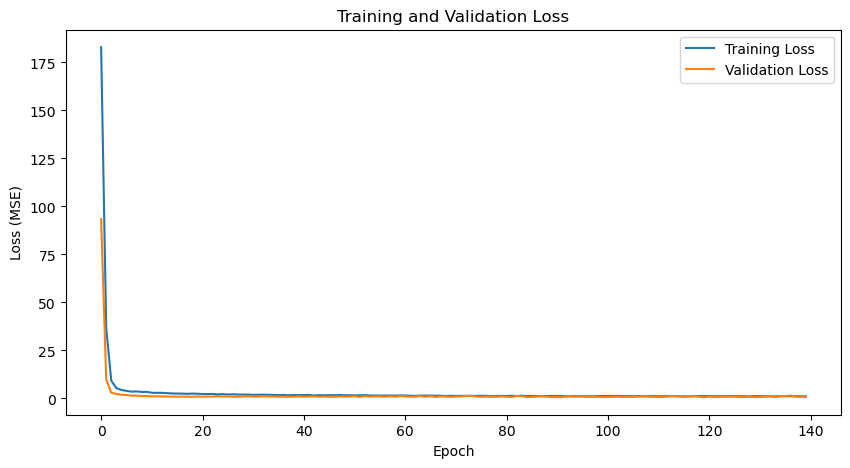

In [36]:
# Build 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(7, 36), padding='same', kernel_regularizer=l2(1e-6)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, padding='same', kernel_regularizer=l2(1e-6)))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(1))  # Regression output

# Compile
optimizer = Adam(learning_rate=0.00025)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, min_delta=0.001)

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test set (inverse transform)
y_pred = model.predict(X_test)
y_pred_inv = np.expm1(y_pred)  # Inverse log1p
y_test_inv = np.expm1(y_test)

# Calculate R² and MAPE
r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
print(f"Test R² Score: {r2}")
print(f"Test MAPE: {mape}%")

# Print sample predictions
print("Sample Predictions:")
for i in range(min(5, len(y_test_inv))):
    print(f"Actual: {y_test_inv[i]:.2f}, Predicted: {y_pred_inv[i][0]:.2f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Save model in native Keras format
model.save('cnn_corn_yield_model.keras')

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define paths
gldas_path = 'Data/gldas_all_bands_data.csv'  
corn_prod_path = 'Data/mn_county_corn_production_2000_2022.csv'

# Load GLDAS data
gldas_df = pd.read_csv(gldas_path)

# Load corn production data
corn_df = pd.read_csv(corn_prod_path)

# Preprocess corn production: melt to long format
corn_df = corn_df.melt(id_vars=['fips', 'county_name'], var_name='year', value_name='production')
corn_df['year'] = corn_df['year'].astype(int)
corn_df['production'] = pd.to_numeric(corn_df['production'], errors='coerce')
corn_df = corn_df.dropna(subset=['production'])
corn_df['fips'] = corn_df['fips'].astype(str).str.zfill(5)

# Clip outliers (95th percentile)
production_cap = corn_df['production'].quantile(0.95)
corn_df['production'] = corn_df['production'].clip(upper=production_cap)

# Preprocess GLDAS: ensure fips is string, filter years 2000-2022
gldas_df['fips'] = gldas_df['fips'].astype(str).str.zfill(5)
gldas_df = gldas_df[gldas_df['year'].between(2000, 2022)]

# Print data summary
print(f"GLDAS unique counties: {len(gldas_df['fips'].unique())}")
print(f"Corn production unique counties: {len(corn_df['fips'].unique())}")
print(f"GLDAS samples: {len(gldas_df)}, Corn samples: {len(corn_df)}")

# Get list of 36 bands
band_columns = [col for col in gldas_df.columns if col not in ['fips', 'county_name', 'year', 'month']]
assert len(band_columns) == 36, f"Expected 36 bands, found {len(band_columns)}"

# Handle missing values
for band in band_columns:
    gldas_df[band] = gldas_df[band].fillna(gldas_df[band].mean())

# Feature selection with Random Forest
def select_top_features(X, y, band_columns, n_features=15):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    X_flat = X.reshape(X.shape[0], -1)  # Flatten to (samples, 7*36)
    rf.fit(X_flat, y)
    importances = rf.feature_importances_
    feature_names = [f"{band}_m{month}" for month in range(2, 9) for band in band_columns]
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    top_features = feature_importance.groupby(feature_names).sum().nlargest(n_features, 'importance').index
    selected_bands = set(f.split('_m')[0] for f in top_features)
    return list(selected_bands)

# Create time-series data
gldas_df = gldas_df.sort_values(['year', 'fips', 'month'])

def group_to_sequence(group, selected_bands):
    if len(group) != 7:
        return None
    sequence = group[selected_bands].values  # Shape: (7, n_selected_bands)
    return sequence

# Initial data preparation for feature selection
sequences = gldas_df.groupby(['year', 'fips']).apply(lambda g: group_to_sequence(g, band_columns)).reset_index(name='sequence')
sequences = sequences.dropna()
data = pd.merge(sequences, corn_df[['year', 'fips', 'production']], on=['year', 'fips'])
X = np.stack(data['sequence'].values)
y = data['production'].values

# Select top 15 bands
selected_bands = select_top_features(X, y, band_columns, n_features=15)
print(f"Selected bands: {selected_bands}")

# Recreate sequences with selected bands
sequences = gldas_df.groupby(['year', 'fips']).apply(lambda g: group_to_sequence(g, selected_bands)).reset_index(name='sequence')
sequences = sequences.dropna()
data = pd.merge(sequences, corn_df[['year', 'fips', 'production']], on=['year', 'fips'])

# Prepare X and y
X = np.stack(data['sequence'].values)  # Shape: (samples, 7 timesteps, n_selected_bands)
y = data['production'].values

# Normalize features
scalers = {}
for i in range(X.shape[2]):
    scalers[i] = StandardScaler()
    X[:, :, i] = scalers[i].fit_transform(X[:, :, i].reshape(-1, 1)).reshape(X.shape[:2])

# Scale target with MinMaxScaler
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Split train/test
train_mask = data['year'] <= 2020
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

# Verify shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Build simplified CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, input_shape=(7, len(selected_bands)), padding='same', kernel_regularizer=l2(1e-5)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, padding='same', kernel_regularizer=l2(1e-5)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(1))

# Compile
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_r2_scores = []
fold_mape_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold + 1}")
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    # Train
    history = model.fit(X_fold_train, y_fold_train, epochs=200, batch_size=32, validation_data=(X_fold_val, y_fold_val),
                       callbacks=[early_stopping, reduce_lr], verbose=1)

    # Evaluate fold
    y_pred_val = model.predict(X_fold_val)
    y_pred_val_inv = y_scaler.inverse_transform(y_pred_val)
    y_fold_val_inv = y_scaler.inverse_transform(y_fold_val.reshape(-1, 1))
    fold_r2 = r2_score(y_fold_val_inv, y_pred_val_inv)
    fold_mape = np.mean(np.abs((y_fold_val_inv - y_pred_val_inv) / y_fold_val_inv)) * 100
    fold_r2_scores.append(fold_r2)
    fold_mape_scores.append(fold_mape)
    print(f"Fold {fold + 1} R²: {fold_r2:.4f}, MAPE: {fold_mape:.2f}%")

print(f"\nMean CV R²: {np.mean(fold_r2_scores):.4f} ± {np.std(fold_r2_scores):.4f}")
print(f"Mean CV MAPE: {np.mean(fold_mape_scores):.2f}% ± {np.std(fold_mape_scores):.2f}%")

# Final training on full train set
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"\nTest Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate R² and MAPE
r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
print(f"Test R² Score: {r2}")
print(f"Test MAPE: {mape}%")

# Print sample predictions with county info
print("\nSample Predictions:")
test_data = data[~train_mask].reset_index(drop=True)
for i in range(min(5, len(y_test_inv))):
    county = test_data.loc[i, 'fips']
    year = test_data.loc[i, 'year']
    print(f"County: {county}, Year: {year}, Actual: {y_test_inv[i]:.2f}, Predicted: {y_pred_inv[i][0]:.2f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Save model
model.save('cnn_corn_yield_model.keras')

GLDAS unique counties: 87
Corn production unique counties: 85
GLDAS samples: 14007, Corn samples: 1868
Selected bands: ['Wind_f_inst', 'Albedo_inst', 'Qg_tavg', 'ESoil_tavg', 'Psurf_f_inst']
X_train shape: (1564, 7, 5), y_train shape: (1564,)
X_test shape: (154, 7, 5), y_test shape: (154,)

Training Fold 1
Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7023 - mae: 0.6411 - val_loss: 0.2388 - val_mae: 0.3895 - learning_rate: 5.0000e-04
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2311 - mae: 0.3666 - val_loss: 0.1757 - val_mae: 0.3349 - learning_rate: 5.0000e-04
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1264 - mae: 0.2753 - val_loss: 0.1577 - val_mae: 0.3172 - learning_rate: 5.0000e-04
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0945 - mae: 0.2388 - val_loss: 0.1380 - val_mae: 0.2943 - learning_rate: 5.0000e-04
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0824 - mae: 0.2216 - val_loss: 0.1062 - val_mae: 0

TypeError: unsupported format string passed to numpy.ndarray.__format__

Number of bands: 36
Bands: ['Albedo_inst', 'AvgSurfT_inst', 'CanopInt_inst', 'ECanop_tavg', 'ESoil_tavg', 'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg', 'PotEvap_tavg', 'Psurf_f_inst', 'Qair_f_inst', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg', 'Qs_acc', 'Qsb_acc', 'Qsm_acc', 'Rainf_f_tavg', 'Rainf_tavg', 'RootMoist_inst', 'SWE_inst', 'SWdown_f_tavg', 'SnowDepth_inst', 'Snowf_tavg', 'SoilMoi0_10cm_inst', 'SoilMoi100_200cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilTMP0_10cm_inst', 'SoilTMP100_200cm_inst', 'SoilTMP10_40cm_inst', 'SoilTMP40_100cm_inst', 'Swnet_tavg', 'Tair_f_inst', 'Tveg_tavg', 'Wind_f_inst']

Data Summary:
Unique counties: 87
Sample count: 14007
Years: 2000 to 2022
Months: 2 to 8

First few rows:
    fips    county_name  Albedo_inst  AvgSurfT_inst  CanopInt_inst  \
0  27073  Lac qui Parle    45.628617     268.901502       0.170420   
1  27153           Todd    56.148677     265.590273       0.206198   
2  27001         Aitkin    50.244838     264.970104       0.175215

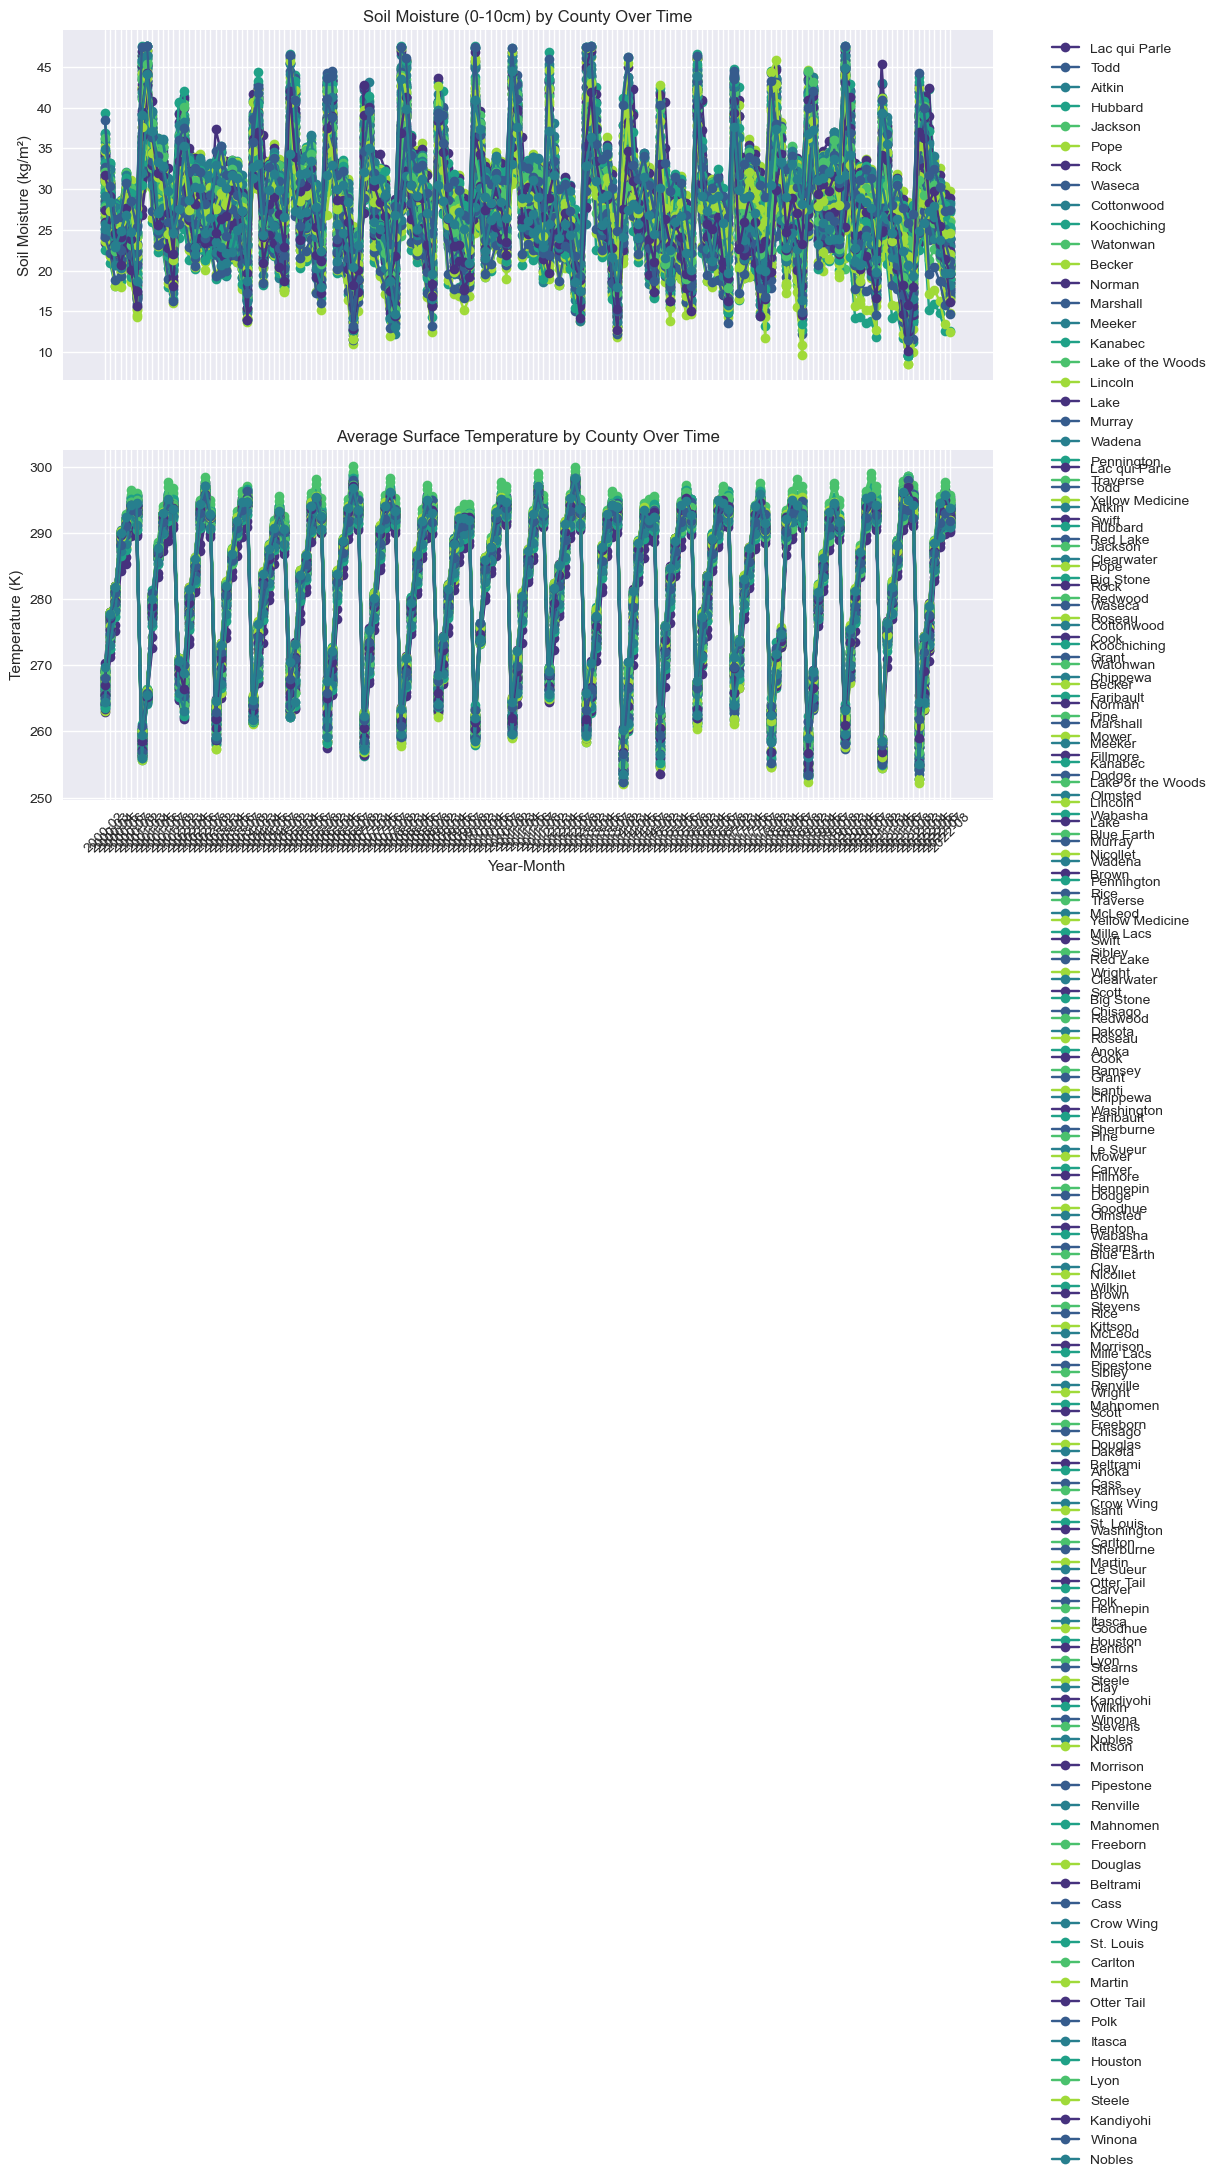

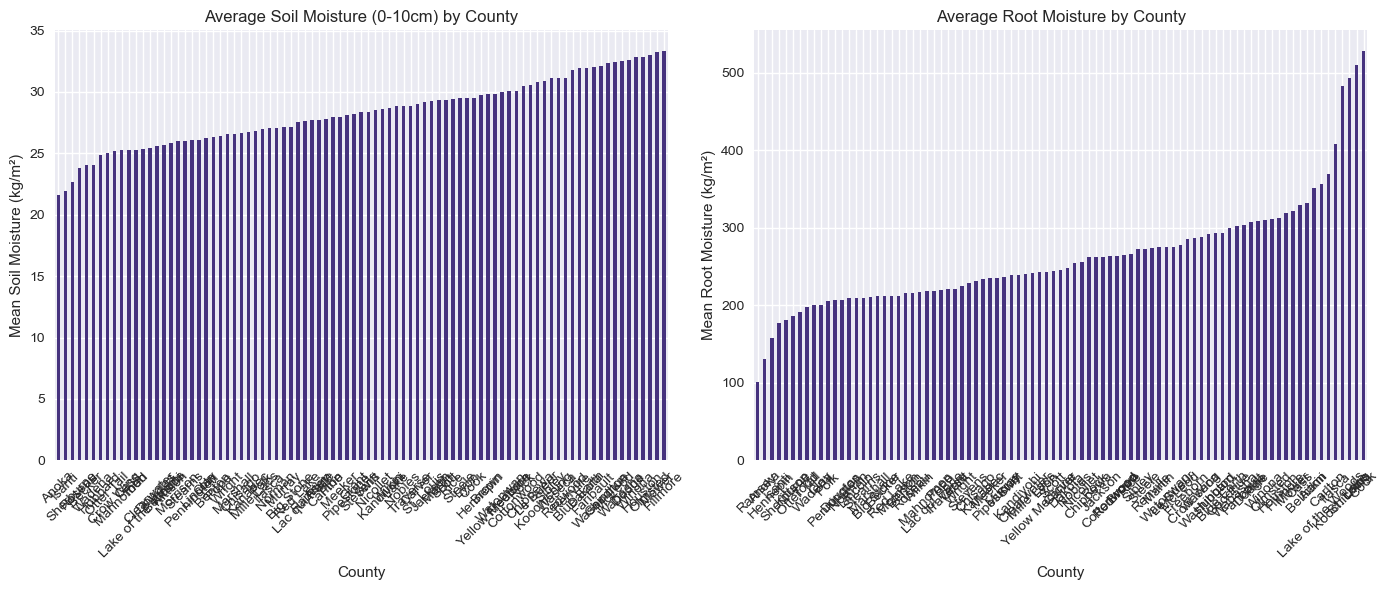

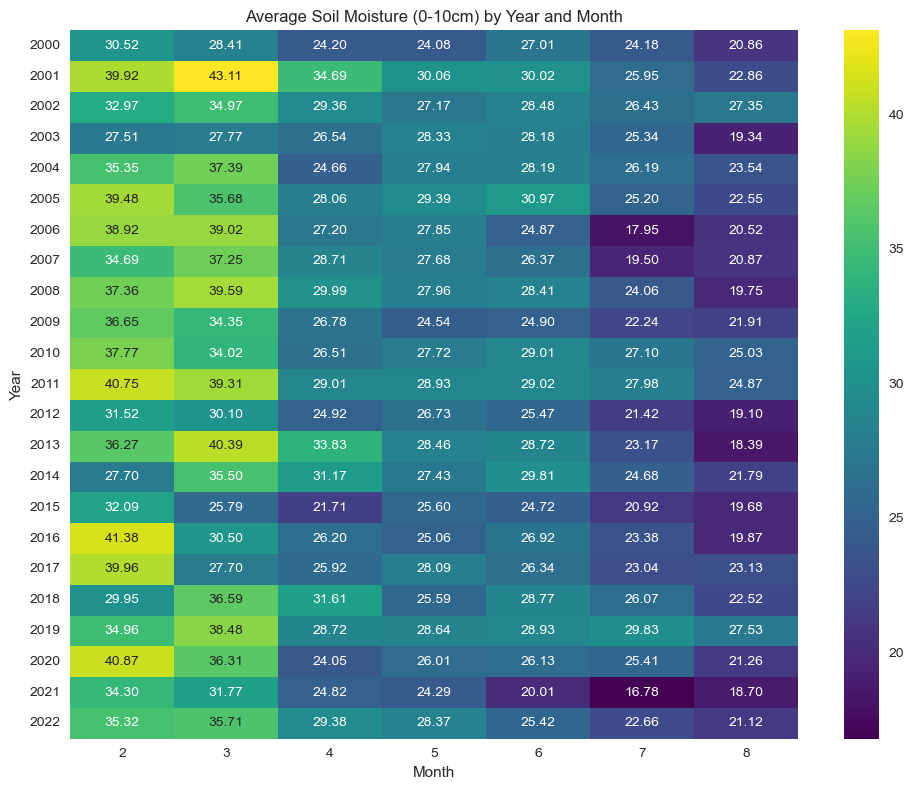

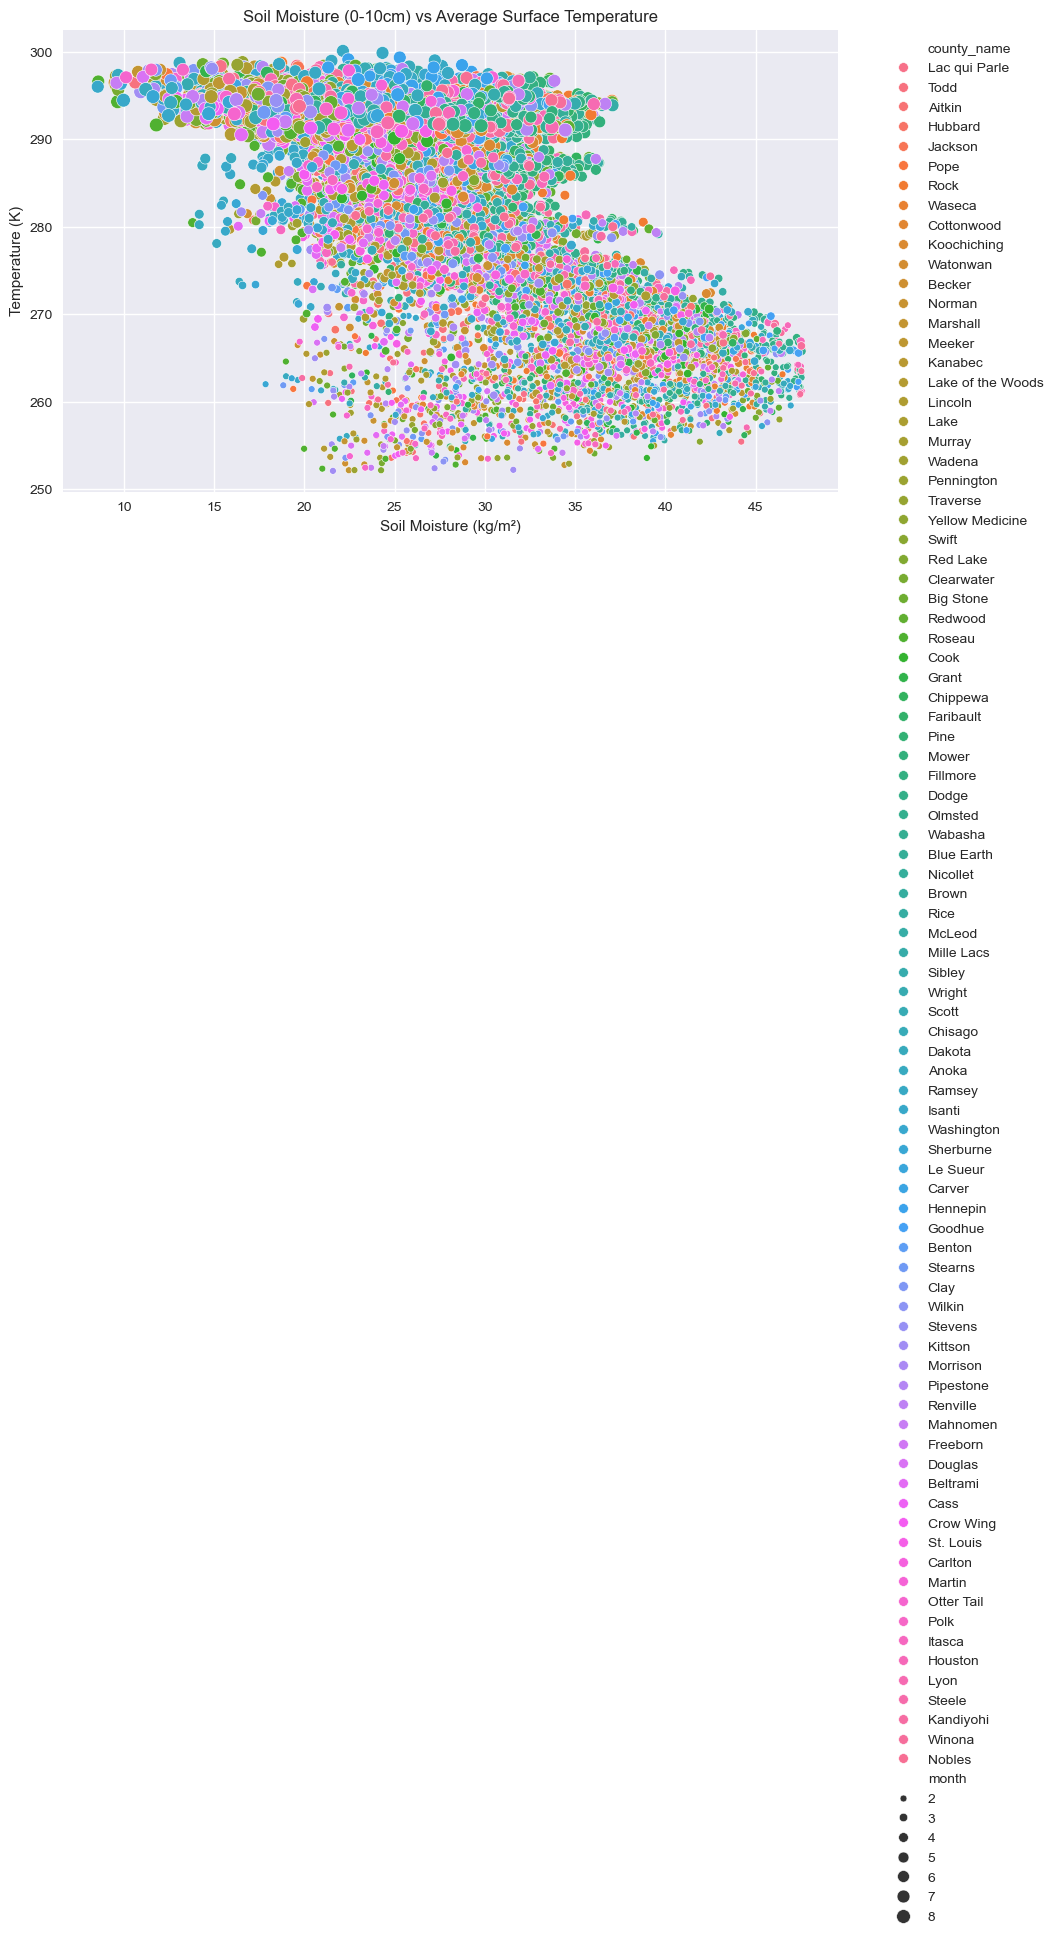

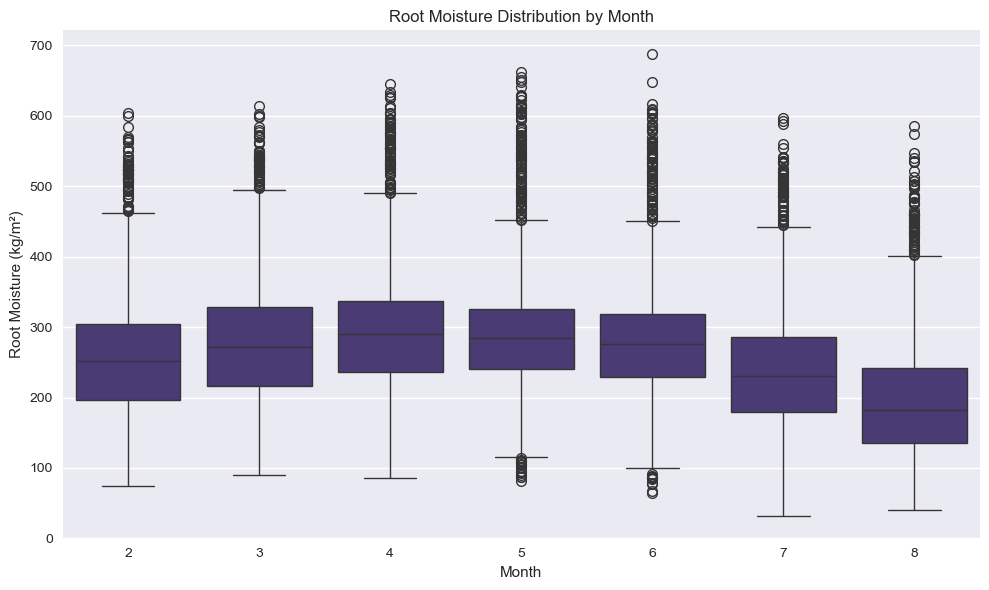

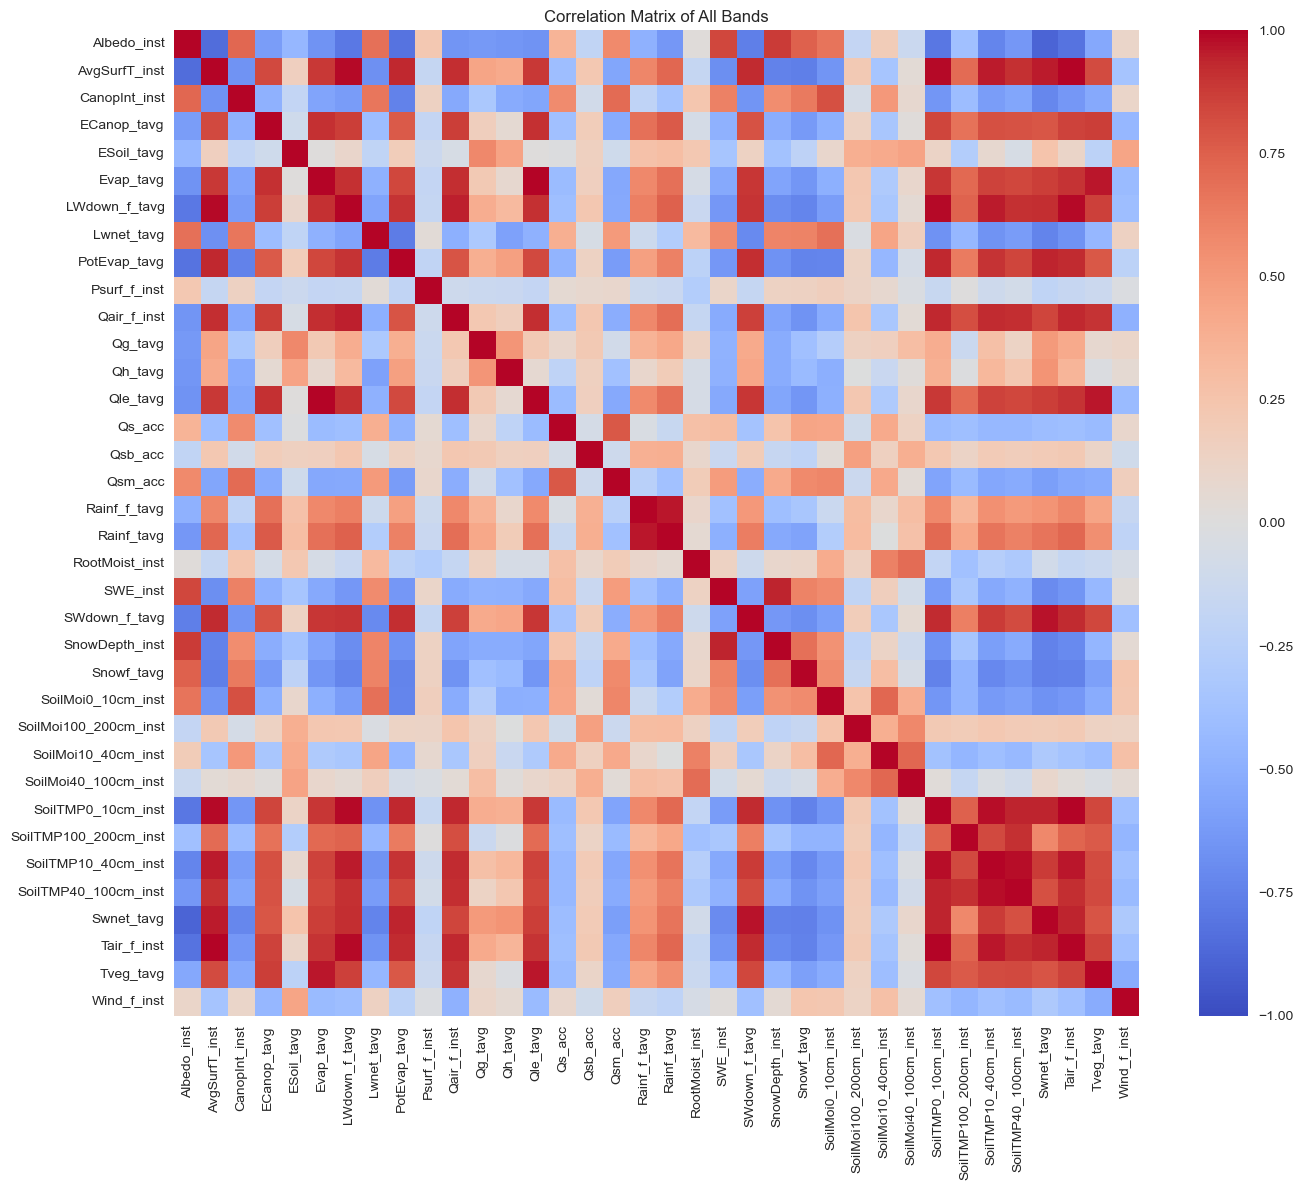

In [42]:
gldas_path = 'Data/gldas_all_bands_data.csv'  

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style (use 'default' if seaborn-v0_8 fails)
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('default')
sns.set_palette('viridis')

# Load GLDAS data
gldas_path = 'Data/gldas_all_bands_data.csv'  
gldas_df = pd.read_csv(gldas_path)

# Ensure fips is string and zero-padded
gldas_df['fips'] = gldas_df['fips'].astype(str).str.zfill(5)

# Create year-month column for plotting
gldas_df['year_month'] = gldas_df['year'].astype(str) + '-' + gldas_df['month'].astype(str).str.zfill(2)

# Define all bands (assuming NDVI is included; update if named differently)
band_columns = [col for col in gldas_df.columns if col not in ['fips', 'county_name', 'year', 'month', 'year_month']]
print(f'Number of bands: {len(band_columns)}')
print(f'Bands: {band_columns}')

# Check if NDVI is present (assuming it’s named 'ndvi'; update if different)
if 'ndvi' not in band_columns:
    print('Warning: NDVI band not found. Please confirm the band name in the dataset.')

# Key bands for visualization (using available GLDAS bands; replace 'ndvi' if needed)
key_bands = ['SoilMoi0_10cm_inst', 'AvgSurfT_inst', 'RootMoist_inst', 'Tveg_tavg']

# Print data summary
print('\nData Summary:')
print(f'Unique counties: {len(gldas_df["fips"].unique())}')
print(f'Sample count: {len(gldas_df)}')
print(f'Years: {gldas_df["year"].min()} to {gldas_df["year"].max()}')
print(f'Months: {gldas_df["month"].min()} to {gldas_df["month"].max()}')
print('\nFirst few rows:')
print(gldas_df.head())

# Descriptive statistics for key bands
print('\nDescriptive Statistics for Key Bands:')
print(gldas_df[key_bands].describe())

# 1. Time-Series Plot: Soil Moisture and Surface Temperature by County
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
for county in gldas_df['county_name'].unique():
    county_data = gldas_df[gldas_df['county_name'] == county]
    ax1.plot(county_data['year_month'], county_data['SoilMoi0_10cm_inst'], label=county, marker='o')
    ax2.plot(county_data['year_month'], county_data['AvgSurfT_inst'], label=county, marker='o')
ax1.set_title('Soil Moisture (0-10cm) by County Over Time')
ax1.set_ylabel('Soil Moisture (kg/m²)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_title('Average Surface Temperature by County Over Time')
ax2.set_xlabel('Year-Month')
ax2.set_ylabel('Temperature (K)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Bar Chart: Average Soil Moisture and Root Moisture by County
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
avg_moisture = gldas_df.groupby('county_name')['SoilMoi0_10cm_inst'].mean().sort_values()
avg_root = gldas_df.groupby('county_name')['RootMoist_inst'].mean().sort_values()
avg_moisture.plot(kind='bar', ax=ax1)
ax1.set_title('Average Soil Moisture (0-10cm) by County')
ax1.set_xlabel('County')
ax1.set_ylabel('Mean Soil Moisture (kg/m²)')
ax1.tick_params(axis='x', rotation=45)
avg_root.plot(kind='bar', ax=ax2)
ax2.set_title('Average Root Moisture by County')
ax2.set_xlabel('County')
ax2.set_ylabel('Mean Root Moisture (kg/m²)')
ax2.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# 3. Heatmap: Average Soil Moisture by Year and Month
pivot_table = gldas_df.pivot_table(values='SoilMoi0_10cm_inst', index='year', columns='month', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.2f')
plt.title('Average Soil Moisture (0-10cm) by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

# 4. Scatter Plot: Soil Moisture vs Surface Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=gldas_df, x='SoilMoi0_10cm_inst', y='AvgSurfT_inst', hue='county_name', size='month')
plt.title('Soil Moisture (0-10cm) vs Average Surface Temperature')
plt.xlabel('Soil Moisture (kg/m²)')
plt.ylabel('Temperature (K)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Box Plot: Root Moisture Distribution by Month
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='RootMoist_inst', data=gldas_df)
plt.title('Root Moisture Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Root Moisture (kg/m²)')
plt.tight_layout()
plt.show()

# 6. Correlation Heatmap: All Bands
plt.figure(figsize=(14, 12))
correlation_matrix = gldas_df[band_columns].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=False)
plt.title('Correlation Matrix of All Bands')
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np

# Load GLDAS data
gldas_path = 'Data/gldas_all_bands_data.csv'
gldas_df = pd.read_csv(gldas_path)

# Load corn production data (pivoted CSV)
corn_prod_path = 'Data/mn_county_corn_production_2000_2022.csv'
corn_pivot = pd.read_csv(corn_prod_path)

# Melt corn production data to long format for merging
corn_df = corn_pivot.melt(id_vars=['fips', 'county_name'], var_name='year', value_name='corn_production_bu')
corn_df['year'] = corn_df['year'].astype(int)
corn_df['corn_production_bu'] = pd.to_numeric(corn_df['corn_production_bu'], errors='coerce')
corn_df['fips'] = corn_df['fips'].astype(str).str.zfill(5)

# Drop rows with missing production
corn_df = corn_df.dropna(subset=['corn_production_bu'])

# Ensure FIPS codes are strings and zero-padded in GLDAS
gldas_df['fips'] = gldas_df['fips'].astype(str).str.zfill(5)
gldas_df['year'] = gldas_df['year'].astype(int)

# Filter GLDAS to Feb-Aug (months 2-8) as per corn planting to harvest timeframe
gldas_df = gldas_df[gldas_df['month'].between(2, 8)]

# Print data summaries before merging
print('GLDAS Data Summary:')
print(f'Unique counties: {len(gldas_df["fips"].unique())}')
print(f'Sample count: {len(gldas_df)}')
print(f'Years: {gldas_df["year"].min()} to {gldas_df["year"].max()}')
print(f'Months: {gldas_df["month"].min()} to {gldas_df["month"].max()}')
print('\nFirst few rows of GLDAS:')
print(gldas_df.head())

print('\nCorn Production Data Summary:')
print(f'Unique counties: {len(corn_df["fips"].unique())}')
print(f'Sample count: {len(corn_df)}')
print(f'Years: {corn_df["year"].min()} to {corn_df["year"].max()}')
print('\nFirst few rows of Corn Production:')
print(corn_df.head())

# Merge GLDAS with corn production on 'fips' and 'year' (annual production duplicated across months)
combined_df = pd.merge(gldas_df, corn_df[['fips', 'year', 'corn_production_bu']], on=['fips', 'year'], how='left')

# Handle missing production values (fill with 0, as some counties/years may lack data)
combined_df['corn_production_bu'] = combined_df['corn_production_bu'].fillna(0)

# Print merged summary
print('\nCombined Data Summary:')
print(f'Sample count: {len(combined_df)}')
print(f'Columns: {combined_df.columns.tolist()}')
print('\nFirst few rows of Combined Data:')
print(combined_df.head())

# Save combined data
combined_df.to_csv('combined_gldas_corn_data.csv', index=False)
print('\nCombined data saved to combined_gldas_corn_data.csv')

GLDAS Data Summary:
Unique counties: 87
Sample count: 14007
Years: 2000 to 2022
Months: 2 to 8

First few rows of GLDAS:
    fips    county_name  Albedo_inst  AvgSurfT_inst  CanopInt_inst  \
0  27073  Lac qui Parle    45.628617     268.901502       0.170420   
1  27153           Todd    56.148677     265.590273       0.206198   
2  27001         Aitkin    50.244838     264.970104       0.175215   
3  27057        Hubbard    48.491914     264.914661       0.210605   
4  27063        Jackson    50.091128     269.441418       0.199066   

   ECanop_tavg  ESoil_tavg  Evap_tavg  LWdown_f_tavg  Lwnet_tavg  ...  \
0     0.094085    4.831143   0.000005     259.458295  -35.648687  ...   
1     0.078237    2.168450   0.000003     249.600736  -31.664551  ...   
2     0.102708    2.679327   0.000004     243.178305  -34.681887  ...   
3     0.095990    2.421774   0.000003     244.762518  -32.901821  ...   
4     0.278989    5.146278   0.000006     262.570152  -35.010630  ...   

   SoilTMP0_10cm_in

Selected bands: ['ESoil_tavg', 'Qg_tavg', 'Psurf_f_inst', 'Tveg_tavg', 'Wind_f_inst', 'SoilTMP100_200cm_inst', 'Albedo_inst', 'RootMoist_inst', 'SoilMoi0_10cm_inst']
X_train shape: (1827, 7, 9), y_train shape: (1827,)
X_test shape: (174, 7, 9), y_test shape: (174,)
Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6960 - mae: 13.4855 - val_loss: 0.0026 - val_mae: 16.1027 - learning_rate: 0.0010
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2749 - mae: 13.2121 - val_loss: 0.0023 - val_mae: 16.0561 - learning_rate: 0.0010
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1348 - mae: 13.1599 - val_loss: 0.0035 - val_mae: 16.0047 - learning_rate: 0.0010
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0920 - mae: 13.1314 - val_loss: 0.0026 - val_mae: 15.9948 - learning_rate: 0.0010
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0673 - mae: 13.1500 - val_loss: 8.5576e-04 - val_mae: 15.9776 - learning_rate: 0.0010
Epoch 6/200
46/

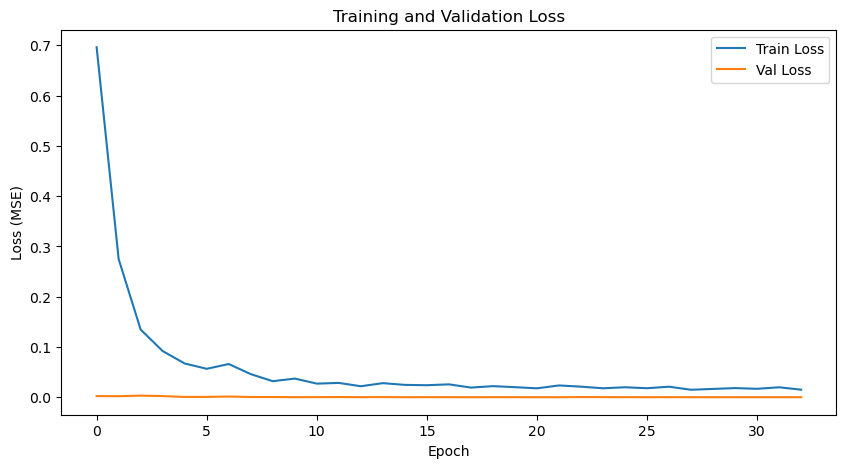

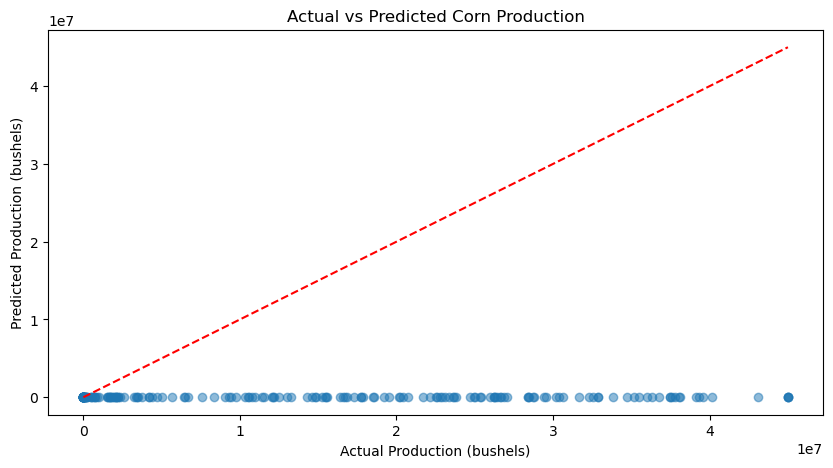

In [25]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

from keras.layers import LeakyReLU
from keras.layers import Flatten

# Load combined data
combined_path = 'combined_gldas_corn_data.csv'
combined_df = pd.read_csv(combined_path)

# Ensure FIPS is string and filter Feb-Aug
combined_df['fips'] = combined_df['fips'].astype(str).str.zfill(5)
combined_df = combined_df[combined_df['month'].between(2, 8)]

# Get band columns
band_columns = [col for col in combined_df.columns if col not in ['fips', 'county_name', 'year', 'month', 'corn_production_bu']]

# Check NDVI presence
if 'ndvi' not in band_columns:
    print('Warning: NDVI band not found in combined data.')

# Impute missing production with county mean
county_means = combined_df.groupby('fips')['corn_production_bu'].mean()
combined_df['corn_production_bu'] = combined_df.apply(
    lambda row: county_means[row['fips']] if pd.isna(row['corn_production_bu']) else row['corn_production_bu'], axis=1
)
combined_df['corn_production_bu'] = combined_df['corn_production_bu'].fillna(combined_df['corn_production_bu'].mean())

# Feature selection with Random Forest
def select_top_features(X, y, band_columns, n_features=15):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    X_flat = X.reshape(X.shape[0], -1)
    rf.fit(X_flat, y)
    importances = rf.feature_importances_
    feature_names = [f"{band}_m{month}" for month in range(2, 9) for band in band_columns]
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.groupby('feature').sum().reset_index()
    top_features = feature_importance.nlargest(n_features, 'importance')['feature']
    selected_bands = set(f.split('_m')[0] for f in top_features)
    must_have = ['SoilMoi0_10cm_inst', 'RootMoist_inst', 'Tveg_tavg']
    if 'ndvi' in band_columns:
        must_have.append('ndvi')
    return list(selected_bands.union(must_have))

# Group by fips-year to create time-series sequences
def group_to_sequence(group, selected_bands):
    if len(group) != 7:  # Ensure 7 months
        return None
    sequence = group[selected_bands].values
    production = group['corn_production_bu'].iloc[0]
    # Access fips and year from group index
    fips = group.index.get_level_values('fips')[0]
    year = group.index.get_level_values('year')[0]
    return pd.Series({'sequence': sequence, 'corn_production_bu': production, 'fips': fips, 'year': year})

# Initial grouping for feature selection
# Group and set index to access fips/year in group_to_sequence
sequences = combined_df.set_index(['fips', 'year']).groupby(['fips', 'year']).apply(
    group_to_sequence, selected_bands=band_columns
).dropna()

# Prepare X and y
X = np.stack(sequences['sequence'].values)
y = sequences['corn_production_bu'].values
fips_years = sequences[['fips', 'year']]

# Select top features
selected_bands = select_top_features(X, y, band_columns, n_features=12)
print(f'Selected bands: {selected_bands}')

# Regroup with selected bands
sequences = combined_df.set_index(['fips', 'year']).groupby(['fips', 'year']).apply(
    group_to_sequence, selected_bands=selected_bands
).dropna()

# Prepare X and y
X = np.stack(sequences['sequence'].values)
y = sequences['corn_production_bu'].values
fips_years = sequences[['fips', 'year']]

# Normalize features
scalers = {}
for i in range(X.shape[2]):
    scalers[i] = StandardScaler()
    X[:, :, i] = scalers[i].fit_transform(X[:, :, i].reshape(-1, 1)).reshape(X.shape[:2])

# Log-transform target and cap
y = np.log1p(y)
production_cap = combined_df['corn_production_bu'].quantile(0.99)
y = np.clip(y, 0, np.log1p(production_cap))

# Sample weights
sample_weights = 1 / (np.expm1(y) + 1)
sample_weights = sample_weights / sample_weights.mean()

# Train/test split
train_mask = sequences['year'] <= 2020
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]
weights_train = sample_weights[train_mask]
test_fips_years = fips_years[~train_mask]

# Verify shapes
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# Build TCN model
def create_tcn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=16, kernel_size=2, padding='causal', dilation_rate=1),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(filters=16, kernel_size=2, padding='causal', dilation_rate=2),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(16),
        LeakyReLU(negative_slope=0.1),
        Dropout(0.2),
        Dense(1)
    ])
    return model

model = create_tcn(input_shape=(7, len(selected_bands)))

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train
history = model.fit(X_train, y_train, sample_weight=weights_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'\nTest Loss (MSE): {test_loss}')
print(f'Test MAE: {test_mae}')

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = np.expm1(y_pred.flatten())
y_pred_inv = np.clip(y_pred_inv, 0, production_cap)
y_test_inv = np.expm1(y_test)

# Metrics
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
print(f'Test R²: {r2}')
print(f'Test MAPE: {mape}%')

# Sample predictions with county info
print('\nSample Predictions:')
for i in range(min(5, len(y_test_inv))):
    county = combined_df[combined_df['fips'] == test_fips_years.iloc[i]['fips']]['county_name'].iloc[0]
    year = test_fips_years.iloc[i]['year']
    print(f'County: {county}, Year: {year}, Actual: {y_test_inv[i]:.2f}, Predicted: {y_pred_inv[i]:.2f}')

# Plot history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
plt.xlabel('Actual Production (bushels)')
plt.ylabel('Predicted Production (bushels)')
plt.title('Actual vs Predicted Corn Production')
plt.show()

# Save model
model.save('tcn_corn_yield_model.keras')


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load the data
df = pd.read_csv('combined_gldas_corn_data.csv')

# Step 2: Define the 36 bands
bands = [
    'Albedo_inst', 'AvgSurfT_inst', 'CanopInt_inst', 'ECanop_tavg', 'ESoil_tavg',
    'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg', 'PotEvap_tavg', 'Psurf_f_inst',
    'Qair_f_inst', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg', 'Qs_acc', 'Qsb_acc', 'Qsm_acc',
    'Rainf_f_tavg', 'Rainf_tavg', 'RootMoist_inst', 'SWE_inst', 'SWdown_f_tavg',
    'SnowDepth_inst', 'Snowf_tavg', 'SoilMoi0_10cm_inst', 'SoilMoi100_200cm_inst',
    'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilTMP0_10cm_inst',
    'SoilTMP100_200cm_inst', 'SoilTMP10_40cm_inst', 'SoilTMP40_100cm_inst',
    'Swnet_tavg', 'Tair_f_inst', 'Tveg_tavg', 'Wind_f_inst'
]

# Step 3: Keep relevant columns
df = df[['fips', 'county_name', 'year', 'month'] + bands + ['corn_production_bu']]

# Step 4: Handle missing production values
df['corn_production_bu'] = df['corn_production_bu'].fillna(0)

# Step 5: Filter for Feb-Aug
df = df[df['month'].between(2, 8)]

# Step 6: Sort by year and month
df = df.sort_values(by=['fips', 'year', 'month'])

# Step 7: Handle incomplete sequences (pad with zeros)
sequences = []
targets = []
groups = df.groupby(['fips', 'year'])
for (fips, year), group in groups:
    if len(group) <= 7:
        seq = group[bands].values
        if len(seq) < 7:
            # Pad with zeros to ensure 7 months
            padding = np.zeros((7 - len(seq), len(bands)))
            seq = np.vstack([seq, padding])
        sequences.append(seq)
        targets.append(group['corn_production_bu'].values[0])

# Convert to numpy arrays
X = np.array(sequences)  # Shape: (num_samples, 7, 36)
y = np.array(targets) / 1_000_000  # Scale target to millions of bushels

# Step 8: Scale features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])

# Step 9: Define TCN Model
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.3):
        super(TCN, self).__init__()
        self.tcn_layers = nn.ModuleList()
        dilations = [1, 2, 4, 8, 16]  # Increased dilations
        for i in range(len(dilations)):
            in_channels = input_size if i == 0 else num_channels
            out_channels = num_channels
            padding = (kernel_size - 1) * dilations[i]
            conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilations[i])
            self.tcn_layers.append(conv)
            self.tcn_layers.append(nn.ReLU())
            self.tcn_layers.append(nn.Dropout(dropout))
            self.tcn_layers.append(nn.BatchNorm1d(out_channels))  # Add batch norm
        self.fc = nn.Linear(num_channels, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, time, features) -> (batch, features, time)
        for layer in self.tcn_layers:
            x = layer(x)
            if isinstance(layer, nn.Conv1d):
                x = x[..., :x.size(2) - layer.padding[0]]  # Crop for causality
        x = x.mean(dim=2)  # Global average pooling
        return self.fc(x)

# Step 10: Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Step 11: K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores, rmse_scores, r2_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}/5")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Step 12: Initialize model
    model = TCN(input_size=len(bands), output_size=1, num_channels=128)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

    # Step 13: Train
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        scheduler.step(loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Step 14: Evaluate
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            outputs = model(batch_X)
            y_pred.extend(outputs.cpu().numpy())
    
    y_pred = np.array(y_pred).squeeze() * 1_000_000  # Rescale predictions
    y_test = y_test.numpy().squeeze() * 1_000_000   # Rescale true values

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    print(f"Fold {fold+1} - MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Step 15: Average metrics
print(f"\nAverage MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Step 16: Example - Predict for new data
# new_X = ... # Shape (1, 7, 36)
# new_X = torch.tensor(new_X, dtype=torch.float32)
# model.eval()
# with torch.no_grad():
#     prediction = model(new_X) * 1_000_000
# print(f"Prediction: {prediction.item()} bushels")


Fold 1/5


C:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  current = float(metrics)


Epoch 10/100, Loss: 30.18279266357422
Epoch 20/100, Loss: 42.40425109863281
Epoch 30/100, Loss: 39.44651794433594
Epoch 40/100, Loss: 28.661619186401367
Epoch 50/100, Loss: 19.032310485839844
Epoch 60/100, Loss: 24.38953399658203
Epoch 70/100, Loss: 19.173587799072266
Epoch 80/100, Loss: 15.969008445739746
Epoch 90/100, Loss: 46.23115921020508
Epoch 100/100, Loss: 32.544368743896484
Fold 1 - MAE: 3479493.25, RMSE: 4995725.024964444, R²: 0.8241205215454102

Fold 2/5
Epoch 10/100, Loss: 4.64365816116333
Epoch 20/100, Loss: 60.55209732055664
Epoch 30/100, Loss: 179.2105712890625
Epoch 40/100, Loss: 189.57470703125
Epoch 50/100, Loss: 15.748607635498047
Epoch 60/100, Loss: 212.1711883544922
Epoch 70/100, Loss: 502.68231201171875
Epoch 80/100, Loss: 113.21803283691406
Epoch 90/100, Loss: 0.7536575198173523
Epoch 100/100, Loss: 77.31233978271484
Fold 2 - MAE: 3943988.5, RMSE: 5885281.23109032, R²: 0.7887623310089111

Fold 3/5
Epoch 10/100, Loss: 4.419058322906494
Epoch 20/100, Loss: 190.8262

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load the data
df = pd.read_csv('combined_gldas_corn_data.csv')

# Step 2: Define the 36 bands
bands = [
    'Albedo_inst', 'AvgSurfT_inst', 'CanopInt_inst', 'ECanop_tavg', 'ESoil_tavg',
    'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg', 'PotEvap_tavg', 'Psurf_f_inst',
    'Qair_f_inst', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg', 'Qs_acc', 'Qsb_acc', 'Qsm_acc',
    'Rainf_f_tavg', 'Rainf_tavg', 'RootMoist_inst', 'SWE_inst', 'SWdown_f_tavg',
    'SnowDepth_inst', 'Snowf_tavg', 'SoilMoi0_10cm_inst', 'SoilMoi100_200cm_inst',
    'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilTMP0_10cm_inst',
    'SoilTMP100_200cm_inst', 'SoilTMP10_40cm_inst', 'SoilTMP40_100cm_inst',
    'Swnet_tavg', 'Tair_f_inst', 'Tveg_tavg', 'Wind_f_inst'
]

# Step 3: Keep relevant columns
df = df[['fips', 'county_name', 'year', 'month'] + bands + ['corn_production_bu']]

# Step 4: Handle missing production values
df['corn_production_bu'] = df['corn_production_bu'].fillna(0)

# Step 5: Filter for Feb-Aug
df = df[df['month'].between(2, 8)]

# Step 6: Sort by year and month
df = df.sort_values(by=['fips', 'year', 'month'])

# Step 7: Handle incomplete sequences (pad with zeros)
sequences = []
targets = []
fips_years = []
groups = df.groupby(['fips', 'year'])
for (fips, year), group in groups:
    if len(group) <= 7:
        seq = group[bands].values
        if len(seq) < 7:
            padding = np.zeros((7 - len(seq), len(bands)))
            seq = np.vstack([seq, padding])
        sequences.append(seq)
        targets.append(group['corn_production_bu'].values[0])
        fips_years.append((fips, year))

# Convert to numpy arrays
X = np.array(sequences)  # Shape: (num_samples, 7, 36)
y = np.array(targets) / 1_000_000  # Scale target to millions of bushels
fips_years = np.array(fips_years)  # Shape: (num_samples, 2)

# Step 8: Scale features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])

# Step 9: Define TCN Model
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.3):
        super(TCN, self).__init__()
        self.tcn_layers = nn.ModuleList()
        dilations = [1, 2, 4, 8, 16]
        for i in range(len(dilations)):
            in_channels = input_size if i == 0 else num_channels
            out_channels = num_channels
            padding = (kernel_size - 1) * dilations[i]
            conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilations[i])
            self.tcn_layers.append(conv)
            self.tcn_layers.append(nn.ReLU())
            self.tcn_layers.append(nn.Dropout(dropout))
            self.tcn_layers.append(nn.BatchNorm1d(out_channels))
        self.fc = nn.Linear(num_channels, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, time, features) -> (batch, features, time)
        for layer in self.tcn_layers:
            x = layer(x)
            if isinstance(layer, nn.Conv1d):
                x = x[..., :x.size(2) - layer.padding[0]]
        x = x.mean(dim=2)
        return self.fc(x)

# Step 10: Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, fips_years=None):
        self.X = X
        self.y = y
        self.fips_years = fips_years

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.fips_years is not None:
            return self.X[idx], self.y[idx], self.fips_years[idx]
        return self.X[idx], self.y[idx]

# Step 11: K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores, rmse_scores, r2_scores = [], [], []
all_predictions = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}/5")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_fips_years = fips_years[test_idx]

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test, test_fips_years)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Step 12: Initialize model
    model = TCN(input_size=len(bands), output_size=1, num_channels=128)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

    # Step 13: Train
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        scheduler.step(loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Step 14: Evaluate and collect predictions
    model.eval()
    y_pred = []
    fold_fips = []
    fold_years = []
    with torch.no_grad():
        for batch_X, batch_y, batch_fips_years in test_loader:
            outputs = model(batch_X)
            y_pred.extend(outputs.cpu().numpy())
            fold_fips.extend(batch_fips_years[:, 0].numpy())
            fold_years.extend(batch_fips_years[:, 1].numpy())

    y_pred = np.array(y_pred).squeeze() * 1_000_000  # Rescale predictions
    y_test = y_test.numpy().squeeze() * 1_000_000   # Rescale true values

    # Store predictions for this fold
    fold_predictions = pd.DataFrame({
        'fips': fold_fips,
        'year': fold_years,
        'actual_production_bu': y_test,
        'predicted_production_bu': y_pred
    })
    all_predictions.append(fold_predictions)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    print(f"Fold {fold+1} - MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Step 15: Average metrics
print(f"\nAverage MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Step 16: Combine all predictions and save to CSV
predictions_df = pd.concat(all_predictions, ignore_index=True)
predictions_df.to_csv('predictions.csv', index=False)
print("\nSaved predictions to 'predictions.csv'")

# Step 17: Example - Predict for new data
# new_X = ... # Shape (1, 7, 36)
# new_X = torch.tensor(new_X, dtype=torch.float32)
# model.eval()
# with torch.no_grad():
#     prediction = model(new_X) * 1_000_000
# print(f"Prediction: {prediction.item()} bushels")


Fold 1/5
Epoch 10/100, Loss: 41.066471099853516
Epoch 20/100, Loss: 22.59496307373047
Epoch 30/100, Loss: 16.944154739379883
Epoch 40/100, Loss: 12.763635635375977
Epoch 50/100, Loss: 19.91185760498047
Epoch 60/100, Loss: 16.391820907592773
Epoch 70/100, Loss: 21.586889266967773
Epoch 80/100, Loss: 26.887849807739258
Epoch 90/100, Loss: 20.943523406982422
Epoch 100/100, Loss: 23.98249626159668
Fold 1 - MAE: 3398056.75, RMSE: 4946664.941000957, R²: 0.8275579810142517

Fold 2/5
Epoch 10/100, Loss: 208.27011108398438
Epoch 20/100, Loss: 156.43206787109375
Epoch 30/100, Loss: 33.86655807495117
Epoch 40/100, Loss: 124.55428314208984
Epoch 50/100, Loss: 6.523173809051514
Epoch 60/100, Loss: 141.64019775390625
Epoch 70/100, Loss: 252.33766174316406
Epoch 80/100, Loss: 247.5371551513672
Epoch 90/100, Loss: 274.858642578125
Epoch 100/100, Loss: 4.425693035125732
Fold 2 - MAE: 3879846.75, RMSE: 5741430.022240801, R²: 0.7989624738693237

Fold 3/5
Epoch 10/100, Loss: 121.55768585205078
Epoch 20/1

PermissionError: [Errno 13] Permission denied: 'predictions.csv'

Data Shape: (15312, 14)
        Name  Longitude  Latitude  Elevation (ft)       date  ppt (inches)  \
0  MilleLacs   -93.6301    45.938            1240 2010-01-01          0.43   
1  MilleLacs   -93.6301    45.938            1240 2010-02-01          0.40   
2  MilleLacs   -93.6301    45.938            1240 2010-03-01          1.10   
3  MilleLacs   -93.6301    45.938            1240 2010-04-01          1.56   
4  MilleLacs   -93.6301    45.938            1240 2010-05-01          4.25   

   tmin (degrees F)  tmean (degrees F)  tmax (degrees F)  tdmean (degrees F)  \
0              -0.8                8.5              17.9                 4.4   
1               2.7               14.5              26.3                 6.5   
2              25.3               36.1              47.0                26.0   
3              35.4               49.0              62.6                31.7   
4              43.6               55.4              67.2                43.1   

   vpdmin (hPa)  vpdmax (h

C:\Users\tngzj\AppData\Local\Temp\ipykernel_9316\3090612514.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='date', y='tmean (degrees F)', hue='Name', ci=None)


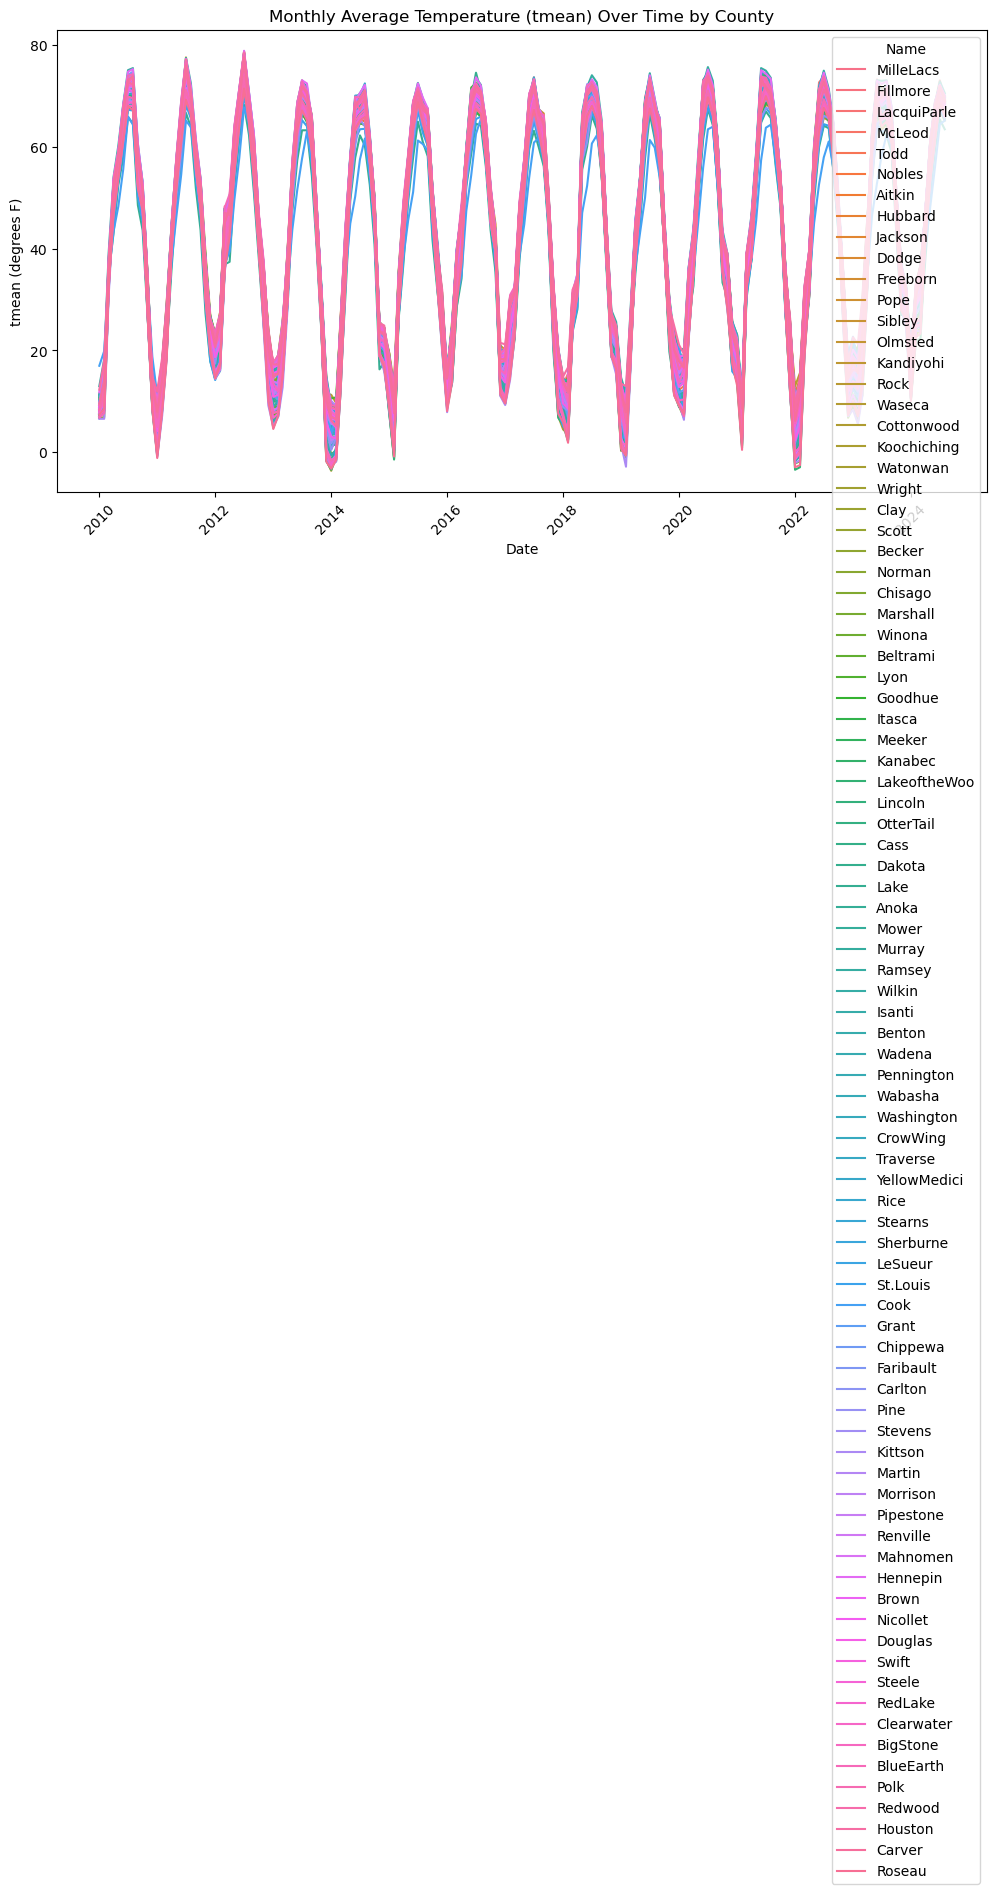

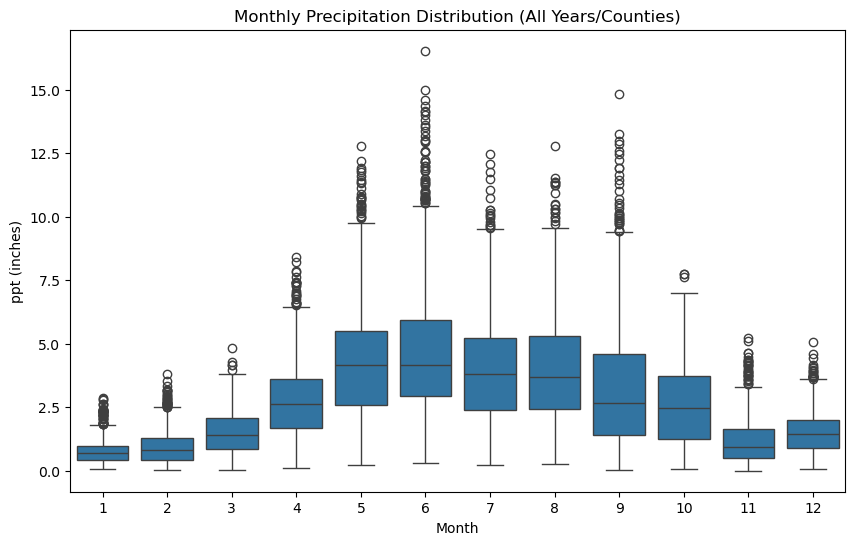

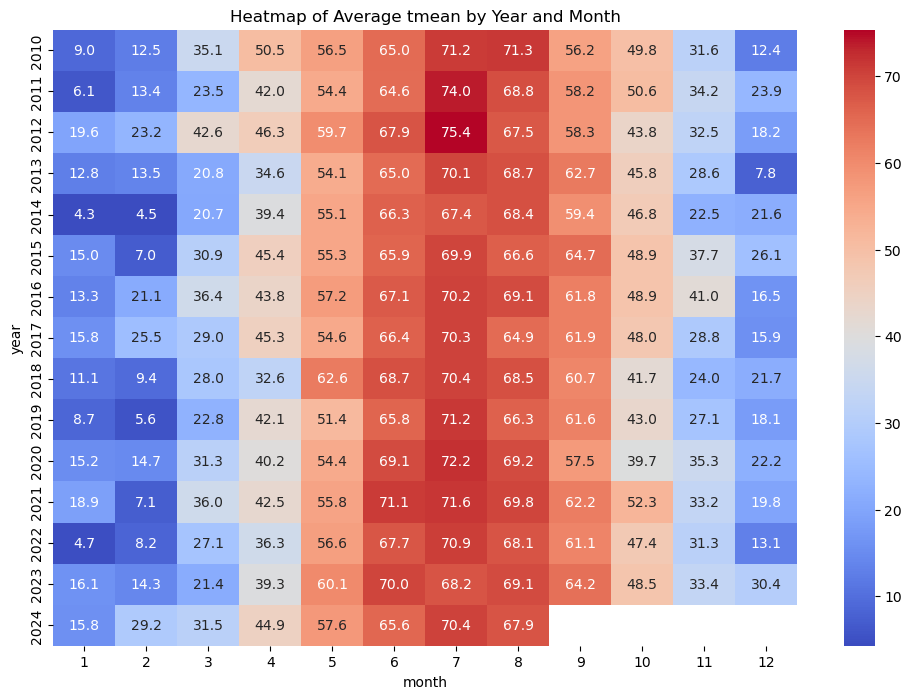

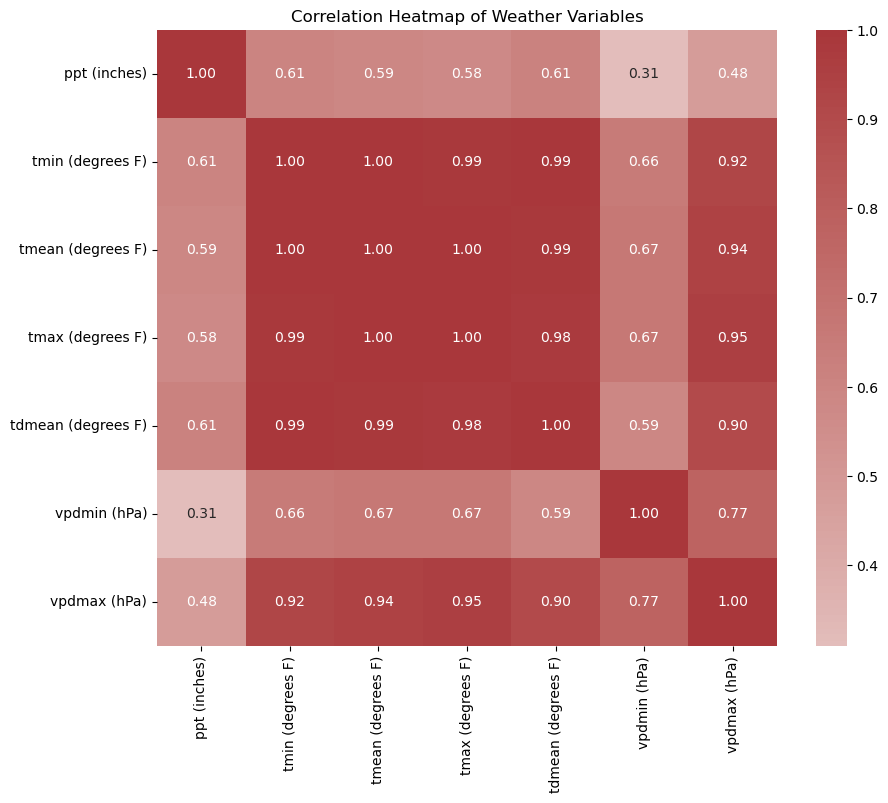

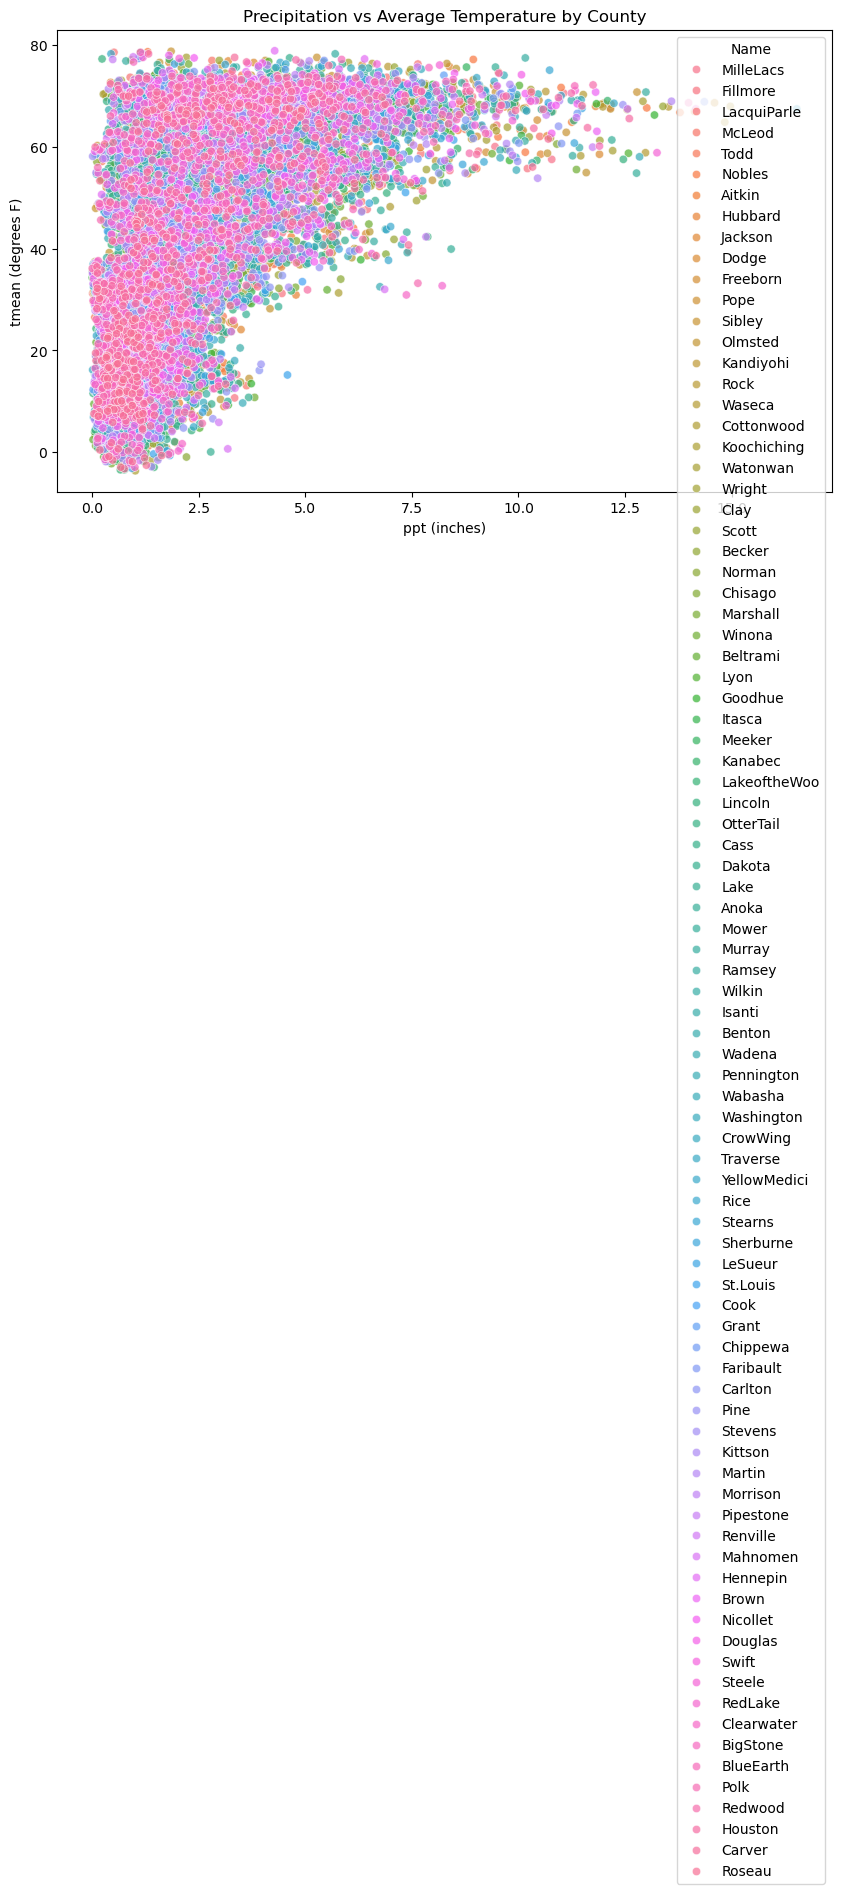

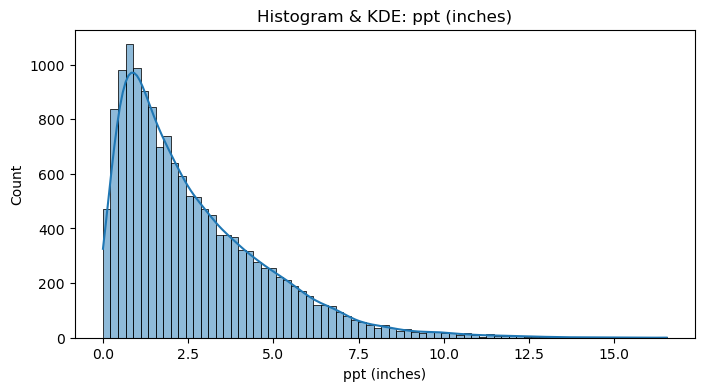

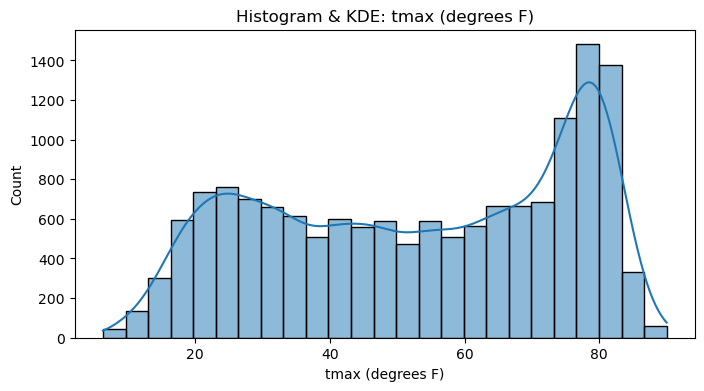

Visualizations complete. Adjust as needed for specific counties or variables.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV (adjust path if needed)
df = pd.read_csv('data/PRISM_ppt_tmin_tmean_tmax_tdmean_vpdmin_vpdmax_stable_4km_201001_202408.csv')

# Data Cleaning
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
# Drop or rename old date if needed
df = df.drop(columns=['Date_old'], errors='ignore')
# Handle any missing values (mean imputation for numeric)
numeric_cols = ['ppt (inches)', 'tmin (degrees F)', 'tmean (degrees F)', 'tmax (degrees F)', 'tdmean (degrees F)', 'vpdmin (hPa)', 'vpdmax (hPa)']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Add year and month for grouping
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Print basic info
print("Data Shape:", df.shape)
print(df.head())
print("\nSummary Stats:")
print(df.describe())

# Visualization 1: Time-Series Line Plot for Average Temperature (tmean) per County
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='tmean (degrees F)', hue='Name', ci=None)
plt.title('Monthly Average Temperature (tmean) Over Time by County')
plt.xlabel('Date')
plt.ylabel('tmean (degrees F)')
plt.xticks(rotation=45)
plt.show()

# Visualization 2: Boxplot for Precipitation (ppt) by Month (Seasonal Distribution)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='month', y='ppt (inches)')
plt.title('Monthly Precipitation Distribution (All Years/Counties)')
plt.xlabel('Month')
plt.ylabel('ppt (inches)')
plt.show()

# Visualization 3: Heatmap of Monthly Averages (e.g., tmean) - Pivot for visualization
pivot_tmean = df.pivot_table(values='tmean (degrees F)', index='year', columns='month', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_tmean, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Heatmap of Average tmean by Year and Month')
plt.show()

# Visualization 4: Correlation Heatmap Among Variables
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation Heatmap of Weather Variables')
plt.show()

# Visualization 5: Scatter Plot (e.g., ppt vs tmean, colored by county)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ppt (inches)', y='tmean (degrees F)', hue='Name', alpha=0.7)
plt.title('Precipitation vs Average Temperature by County')
plt.show()

# Visualization 6: Histogram + KDE for Key Variables (e.g., ppt and tmax)
for col in ['ppt (inches)', 'tmax (degrees F)']:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram & KDE: {col}')
    plt.show()

print("Visualizations complete. Adjust as needed for specific counties or variables.")